In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")

In [3]:
import os
from os.path import join
import pickle as pkl
import torch
from easydict import EasyDict as edict
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import einops

In [4]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.edgecolor'] = (1, 1, 1, 0)
plt.rcParams['figure.facecolor'] = (1, 1, 1, 0)
# vector graphics type
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [5]:
from train_edm import create_model, edm_sampler, EDM
from edm_utils import edm_sampler_inpaint, create_edm, get_default_config
from rule_utils import get_rule_img, get_obj_list, get_rule_list
from rule_utils import check_consistent
from dataset_utils import train_data2attr_tsr,load_raw_data,load_PGM_abstract

### Load Train inputs

In [6]:
from dataset_utils import train_data2attr_tsr, load_raw_data, load_PGM_abstract
d_PGM, train_inputs = load_raw_data("..")

torch.Size([35, 10000, 3, 9, 3])


### Int Feature encoding

In [7]:
DATASET="RAVEN10_abstract"
config_ft = get_default_config(DATASET)
# config_ft = edict()
# config_ft.channel_mult = [1, 2, 4, 4]
# config_ft.model_channels = 64
# config_ft.attn_resolutions = [0,1,2]
# config_ft.layers_per_block = 1
# config_ft.num_fid_sample = 5000
# config_ft.fid_batch_size = 1024
# config_ft.channels = 3
# config_ft.img_size = 9
# config_ft.device = "cuda"
# config_ft.sigma_min = 0.002
# config_ft.sigma_max = 80.0
# config_ft.rho = 7.0 
# config_ft.sigma_data = 0.5
device = "cuda"

In [8]:
Xmean = torch.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to(device)
Xstd = torch.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to(device)

In [15]:
!cd $WORK_DIR/DL_Projects/mini_edm/exps;pwd

/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps


In [16]:
epoch = 99999
ckptdir = r"/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/base_RAVEN10_abstract_20240201-0036/checkpoints"
edm, model = create_edm(ckptdir + f"/ema_{epoch}.pth", config_ft, device) 

In [17]:
model

SongUNet(
  (map_noise): PositionalEmbedding()
  (map_augment): Linear()
  (map_layer0): Linear()
  (map_layer1): Linear()
  (enc): ModuleDict(
    (9x9_conv): Conv2d()
    (9x9_block0): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
    )
    (4x4_down): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
      (skip): Conv2d()
    )
    (4x4_block0): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
      (skip): Conv2d()
    )
    (2x2_down): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
      (skip): Conv2d()
    )
    (2x2_block0): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1)

In [45]:
latents = torch.randn(1024, 3, 9, 9).to(device)
samples = edm_sampler(edm, latents, num_steps=18)
samples = samples * Xstd + Xmean

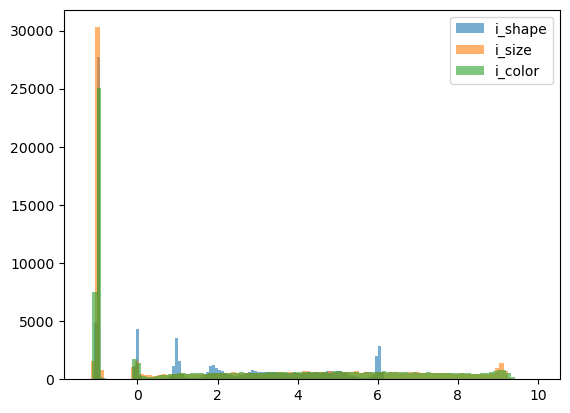

In [48]:
plt.hist(samples[:, 0].cpu().numpy().flatten(), bins=100, alpha=0.6, label="i_shape")
plt.hist(samples[:, 1].cpu().numpy().flatten(), bins=100, alpha=0.6, label="i_size")
plt.hist(samples[:, 2].cpu().numpy().flatten(), bins=100, alpha=0.6, label="i_color")
plt.legend()
plt.show()

In [74]:
latents = torch.randn(4096, 3, 9, 9).to(device)
samples = edm_sampler(edm, latents, num_steps=25)
samples = samples * Xstd + Xmean
samples_int = torch.round(samples).long().cpu()

In [72]:
rules_col = []
for sample_rows in samples_int:
    sample_rules = get_rule_img(sample_rows)
    rules_col.append(sample_rules)
rules_col = np.asarray(rules_col)

consistent_vec = [check_consistent(rules) for rules in rules_col]
consistent_vec = np.asarray(consistent_vec)

In [73]:
print("Three of a kind: ", (consistent_vec==1).sum(), "frac", (consistent_vec==1).mean())
print("Two of a kind: ", (consistent_vec==2).sum(), "frac", (consistent_vec==2).mean())
print("Not total failure", (consistent_vec==3).sum(), "frac", (consistent_vec==3).mean())

Three of a kind:  82 frac 0.02001953125
Two of a kind:  328 frac 0.080078125
Not total failure 1623 frac 0.396240234375


In [84]:
ckptdir = r"/n/home12/binxuwang/Github/mini_edm/exps/base_RAVEN10_abstract_20240201-0036/checkpoints"
epoch_list = [*range(2000, 100000, 2000)] + [99999]
num_steps = 25
rules_all = []
samples_all = []
consistent_vec_all = []
for epoch in tqdm(epoch_list):
    edm, model = create_edm(ckptdir + f"/ema_{epoch}.pth", config_ft, device) 
    # generate samples
    latents = torch.randn(4096, 3, 9, 9).to(device)
    samples = edm_sampler(edm, latents, num_steps=num_steps)
    samples = samples * Xstd + Xmean
    samples_int = torch.round(samples).long().cpu()
    # infer rules
    rules_col = []
    for sample_rows in samples_int:
        sample_rules = get_rule_img(sample_rows)
        rules_col.append(sample_rules)
    rules_col = np.asarray(rules_col)
    # check consistency
    consistent_vec = [check_consistent(rules) for rules in rules_col]
    consistent_vec = np.asarray(consistent_vec)
    print("Epoch", epoch)
    print("Three of a kind: ", (consistent_vec==1).sum(), "frac", (consistent_vec==1).mean())
    print("Two of a kind: ", (consistent_vec==2).sum(), "frac", (consistent_vec==2).mean())
    print("Not total failure", (consistent_vec==3).sum(), "frac", (consistent_vec==3).mean())
    rules_all.append(rules_col)
    samples_all.append(samples)
    consistent_vec_all.append(consistent_vec)

  2%|██                                                                                                  | 1/50 [00:10<08:54, 10.91s/it]

Epoch 2000
Three of a kind:  0 frac 0.0
Two of a kind:  28 frac 0.0068359375
Not total failure 1159 frac 0.282958984375


  4%|████                                                                                                | 2/50 [00:21<08:36, 10.76s/it]

Epoch 4000
Three of a kind:  0 frac 0.0
Two of a kind:  14 frac 0.00341796875
Not total failure 1077 frac 0.262939453125


  6%|██████                                                                                              | 3/50 [00:32<08:21, 10.67s/it]

Epoch 6000
Three of a kind:  0 frac 0.0
Two of a kind:  12 frac 0.0029296875
Not total failure 1083 frac 0.264404296875


  8%|████████                                                                                            | 4/50 [00:42<08:08, 10.63s/it]

Epoch 8000
Three of a kind:  0 frac 0.0
Two of a kind:  19 frac 0.004638671875
Not total failure 1052 frac 0.2568359375


 10%|██████████                                                                                          | 5/50 [00:53<07:57, 10.62s/it]

Epoch 10000
Three of a kind:  2 frac 0.00048828125
Two of a kind:  16 frac 0.00390625
Not total failure 1143 frac 0.279052734375


 12%|████████████                                                                                        | 6/50 [01:03<07:46, 10.61s/it]

Epoch 12000
Three of a kind:  0 frac 0.0
Two of a kind:  18 frac 0.00439453125
Not total failure 1099 frac 0.268310546875


 14%|██████████████                                                                                      | 7/50 [01:14<07:36, 10.63s/it]

Epoch 14000
Three of a kind:  1 frac 0.000244140625
Two of a kind:  23 frac 0.005615234375
Not total failure 1088 frac 0.265625


 16%|████████████████                                                                                    | 8/50 [01:25<07:28, 10.68s/it]

Epoch 16000
Three of a kind:  0 frac 0.0
Two of a kind:  27 frac 0.006591796875
Not total failure 1159 frac 0.282958984375


 18%|██████████████████                                                                                  | 9/50 [01:35<07:15, 10.61s/it]

Epoch 18000
Three of a kind:  0 frac 0.0
Two of a kind:  21 frac 0.005126953125
Not total failure 1188 frac 0.2900390625


 20%|███████████████████▊                                                                               | 10/50 [01:46<07:03, 10.59s/it]

Epoch 20000
Three of a kind:  0 frac 0.0
Two of a kind:  25 frac 0.006103515625
Not total failure 1233 frac 0.301025390625


 22%|█████████████████████▊                                                                             | 11/50 [01:56<06:52, 10.58s/it]

Epoch 22000
Three of a kind:  0 frac 0.0
Two of a kind:  44 frac 0.0107421875
Not total failure 1205 frac 0.294189453125


 24%|███████████████████████▊                                                                           | 12/50 [02:07<06:40, 10.55s/it]

Epoch 24000
Three of a kind:  0 frac 0.0
Two of a kind:  29 frac 0.007080078125
Not total failure 1239 frac 0.302490234375


 26%|█████████████████████████▋                                                                         | 13/50 [02:17<06:30, 10.55s/it]

Epoch 26000
Three of a kind:  0 frac 0.0
Two of a kind:  36 frac 0.0087890625
Not total failure 1310 frac 0.31982421875


 28%|███████████████████████████▋                                                                       | 14/50 [02:28<06:17, 10.50s/it]

Epoch 28000
Three of a kind:  1 frac 0.000244140625
Two of a kind:  40 frac 0.009765625
Not total failure 1337 frac 0.326416015625


 30%|█████████████████████████████▋                                                                     | 15/50 [02:38<06:05, 10.45s/it]

Epoch 30000
Three of a kind:  0 frac 0.0
Two of a kind:  42 frac 0.01025390625
Not total failure 1339 frac 0.326904296875


 32%|███████████████████████████████▋                                                                   | 16/50 [02:49<05:56, 10.49s/it]

Epoch 32000
Three of a kind:  0 frac 0.0
Two of a kind:  39 frac 0.009521484375
Not total failure 1351 frac 0.329833984375


 34%|█████████████████████████████████▋                                                                 | 17/50 [02:59<05:45, 10.47s/it]

Epoch 34000
Three of a kind:  2 frac 0.00048828125
Two of a kind:  59 frac 0.014404296875
Not total failure 1376 frac 0.3359375


 36%|███████████████████████████████████▋                                                               | 18/50 [03:10<05:37, 10.53s/it]

Epoch 36000
Three of a kind:  2 frac 0.00048828125
Two of a kind:  56 frac 0.013671875
Not total failure 1411 frac 0.344482421875


 38%|█████████████████████████████████████▌                                                             | 19/50 [03:20<05:25, 10.51s/it]

Epoch 38000
Three of a kind:  4 frac 0.0009765625
Two of a kind:  69 frac 0.016845703125
Not total failure 1422 frac 0.34716796875


 40%|███████████████████████████████████████▌                                                           | 20/50 [03:31<05:16, 10.56s/it]

Epoch 40000
Three of a kind:  4 frac 0.0009765625
Two of a kind:  85 frac 0.020751953125
Not total failure 1482 frac 0.36181640625


 42%|█████████████████████████████████████████▌                                                         | 21/50 [03:41<05:01, 10.41s/it]

Epoch 42000
Three of a kind:  1 frac 0.000244140625
Two of a kind:  73 frac 0.017822265625
Not total failure 1504 frac 0.3671875


 44%|███████████████████████████████████████████▌                                                       | 22/50 [03:52<04:53, 10.48s/it]

Epoch 44000
Three of a kind:  5 frac 0.001220703125
Two of a kind:  76 frac 0.0185546875
Not total failure 1423 frac 0.347412109375


 46%|█████████████████████████████████████████████▌                                                     | 23/50 [04:02<04:38, 10.33s/it]

Epoch 46000
Three of a kind:  7 frac 0.001708984375
Two of a kind:  97 frac 0.023681640625
Not total failure 1456 frac 0.35546875


 48%|███████████████████████████████████████████████▌                                                   | 24/50 [04:12<04:32, 10.48s/it]

Epoch 48000
Three of a kind:  5 frac 0.001220703125
Two of a kind:  104 frac 0.025390625
Not total failure 1466 frac 0.35791015625


 50%|█████████████████████████████████████████████████▌                                                 | 25/50 [04:23<04:20, 10.43s/it]

Epoch 50000
Three of a kind:  6 frac 0.00146484375
Two of a kind:  114 frac 0.02783203125
Not total failure 1552 frac 0.37890625


 52%|███████████████████████████████████████████████████▍                                               | 26/50 [04:33<04:09, 10.38s/it]

Epoch 52000
Three of a kind:  12 frac 0.0029296875
Two of a kind:  133 frac 0.032470703125
Not total failure 1496 frac 0.365234375


 54%|█████████████████████████████████████████████████████▍                                             | 27/50 [04:44<04:00, 10.45s/it]

Epoch 54000
Three of a kind:  20 frac 0.0048828125
Two of a kind:  130 frac 0.03173828125
Not total failure 1543 frac 0.376708984375


 56%|███████████████████████████████████████████████████████▍                                           | 28/50 [04:54<03:50, 10.47s/it]

Epoch 56000
Three of a kind:  11 frac 0.002685546875
Two of a kind:  157 frac 0.038330078125
Not total failure 1521 frac 0.371337890625


 58%|█████████████████████████████████████████████████████████▍                                         | 29/50 [05:05<03:40, 10.50s/it]

Epoch 58000
Three of a kind:  18 frac 0.00439453125
Two of a kind:  152 frac 0.037109375
Not total failure 1585 frac 0.386962890625


 60%|███████████████████████████████████████████████████████████▍                                       | 30/50 [05:15<03:30, 10.53s/it]

Epoch 60000
Three of a kind:  16 frac 0.00390625
Two of a kind:  183 frac 0.044677734375
Not total failure 1563 frac 0.381591796875


 62%|█████████████████████████████████████████████████████████████▍                                     | 31/50 [05:26<03:20, 10.53s/it]

Epoch 62000
Three of a kind:  25 frac 0.006103515625
Two of a kind:  159 frac 0.038818359375
Not total failure 1564 frac 0.3818359375


 64%|███████████████████████████████████████████████████████████████▎                                   | 32/50 [05:36<03:07, 10.40s/it]

Epoch 64000
Three of a kind:  22 frac 0.00537109375
Two of a kind:  180 frac 0.0439453125
Not total failure 1590 frac 0.38818359375


 66%|█████████████████████████████████████████████████████████████████▎                                 | 33/50 [05:46<02:56, 10.36s/it]

Epoch 66000
Three of a kind:  20 frac 0.0048828125
Two of a kind:  199 frac 0.048583984375
Not total failure 1573 frac 0.384033203125


 68%|███████████████████████████████████████████████████████████████████▎                               | 34/50 [05:56<02:45, 10.32s/it]

Epoch 68000
Three of a kind:  23 frac 0.005615234375
Two of a kind:  202 frac 0.04931640625
Not total failure 1560 frac 0.380859375


 70%|█████████████████████████████████████████████████████████████████████▎                             | 35/50 [06:07<02:33, 10.25s/it]

Epoch 70000
Three of a kind:  30 frac 0.00732421875
Two of a kind:  201 frac 0.049072265625
Not total failure 1540 frac 0.3759765625


 72%|███████████████████████████████████████████████████████████████████████▎                           | 36/50 [06:17<02:23, 10.27s/it]

Epoch 72000
Three of a kind:  23 frac 0.005615234375
Two of a kind:  233 frac 0.056884765625
Not total failure 1574 frac 0.38427734375


 74%|█████████████████████████████████████████████████████████████████████████▎                         | 37/50 [06:27<02:12, 10.17s/it]

Epoch 74000
Three of a kind:  32 frac 0.0078125
Two of a kind:  213 frac 0.052001953125
Not total failure 1536 frac 0.375


 76%|███████████████████████████████████████████████████████████████████████████▏                       | 38/50 [06:37<02:02, 10.21s/it]

Epoch 76000
Three of a kind:  24 frac 0.005859375
Two of a kind:  229 frac 0.055908203125
Not total failure 1603 frac 0.391357421875


 78%|█████████████████████████████████████████████████████████████████████████████▏                     | 39/50 [06:48<01:53, 10.30s/it]

Epoch 78000
Three of a kind:  34 frac 0.00830078125
Two of a kind:  205 frac 0.050048828125
Not total failure 1622 frac 0.39599609375


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 40/50 [06:58<01:42, 10.26s/it]

Epoch 80000
Three of a kind:  27 frac 0.006591796875
Two of a kind:  264 frac 0.064453125
Not total failure 1576 frac 0.384765625


 82%|█████████████████████████████████████████████████████████████████████████████████▏                 | 41/50 [07:08<01:33, 10.37s/it]

Epoch 82000
Three of a kind:  50 frac 0.01220703125
Two of a kind:  246 frac 0.06005859375
Not total failure 1566 frac 0.38232421875


 84%|███████████████████████████████████████████████████████████████████████████████████▏               | 42/50 [07:19<01:22, 10.32s/it]

Epoch 84000
Three of a kind:  38 frac 0.00927734375
Two of a kind:  254 frac 0.06201171875
Not total failure 1616 frac 0.39453125


 86%|█████████████████████████████████████████████████████████████████████████████████████▏             | 43/50 [07:29<01:12, 10.35s/it]

Epoch 86000
Three of a kind:  54 frac 0.01318359375
Two of a kind:  254 frac 0.06201171875
Not total failure 1555 frac 0.379638671875


 88%|███████████████████████████████████████████████████████████████████████████████████████            | 44/50 [07:39<01:02, 10.37s/it]

Epoch 88000
Three of a kind:  54 frac 0.01318359375
Two of a kind:  290 frac 0.07080078125
Not total failure 1580 frac 0.3857421875


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 45/50 [07:50<00:51, 10.30s/it]

Epoch 90000
Three of a kind:  44 frac 0.0107421875
Two of a kind:  254 frac 0.06201171875
Not total failure 1551 frac 0.378662109375


 92%|███████████████████████████████████████████████████████████████████████████████████████████        | 46/50 [08:00<00:41, 10.29s/it]

Epoch 92000
Three of a kind:  55 frac 0.013427734375
Two of a kind:  277 frac 0.067626953125
Not total failure 1534 frac 0.37451171875


 94%|█████████████████████████████████████████████████████████████████████████████████████████████      | 47/50 [08:10<00:30, 10.30s/it]

Epoch 94000
Three of a kind:  65 frac 0.015869140625
Two of a kind:  267 frac 0.065185546875
Not total failure 1575 frac 0.384521484375


 96%|███████████████████████████████████████████████████████████████████████████████████████████████    | 48/50 [08:20<00:20, 10.19s/it]

Epoch 96000
Three of a kind:  67 frac 0.016357421875
Two of a kind:  307 frac 0.074951171875
Not total failure 1568 frac 0.3828125


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████  | 49/50 [08:30<00:10, 10.21s/it]

Epoch 98000
Three of a kind:  56 frac 0.013671875
Two of a kind:  330 frac 0.08056640625
Not total failure 1522 frac 0.37158203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [08:37<00:00, 10.35s/it]

Epoch 99999
Three of a kind:  76 frac 0.0185546875
Two of a kind:  313 frac 0.076416015625
Not total failure 1597 frac 0.389892578125


In [85]:
rules_all = np.asarray(rules_all)
consistent_vec_all = np.asarray(consistent_vec_all)
samples_all_col = [torch.round(samples).long().cpu() for samples in samples_all] 
samples_all_col = torch.stack(samples_all_col, dim=0)

In [96]:
expdir = r"/n/home12/binxuwang/Github/mini_edm/exps/base_RAVEN10_abstract_20240201-0036/"
torch.save({"samples_all_col":samples_all_col, 
            "epoch_list":epoch_list,},
        (expdir+"RAVEN10_abstract_more_samples.pth"))
np.savez(expdir+"RAVEN10_abstract_more_infer_rules.npz", 
         rules_all=rules_all, consistent_vec_all=consistent_vec_all,
         epoch_list=epoch_list)

In [105]:
import scipy.stats as stats

def estimate_CI(count, total, alpha=0.05):
    """estimate the confidence interval of a ratio"""
    p = count / total
    n = total
    lower = stats.binom.ppf(alpha/2, n, p)
    upper = stats.binom.ppf(1-alpha/2, n, p)
    return lower/n, upper/n


def shaded_error(ax, x, y, yerr_low, yerr_high, label=None, color=None, alpha=0.3):
    ax.plot(x, y, label=label, color=color)
    ax.fill_between(x, yerr_low, yerr_high, alpha=alpha, color=color)

# estimate_CI((consistent_vec_all==1).sum(axis=1), 4096, alpha=0.05)

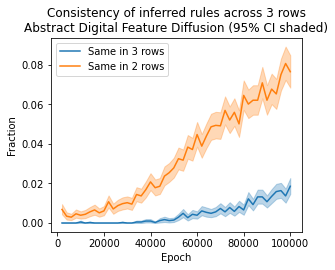

In [113]:
plt.figure(figsize=(4.5, 3.5))
CI_low, CI_high = estimate_CI((consistent_vec_all==1).sum(axis=1), 4096, alpha=0.05)
shaded_error(plt.gca(), epoch_list, (consistent_vec_all==1).mean(axis=1),
                CI_low, CI_high, label="Same in 3 rows", color="C0")
CI_low, CI_high = estimate_CI((consistent_vec_all==2).sum(axis=1), 4096, alpha=0.05)
shaded_error(plt.gca(), epoch_list, (consistent_vec_all==2).mean(axis=1),
                CI_low, CI_high, label="Same in 2 rows", color="C1")
# plt.plot(epoch_list, (consistent_vec_all==1).mean(axis=1), label="Same in 3 rows")
# plt.plot(epoch_list, (consistent_vec_all==2).mean(axis=1), label="Same in 2 rows")
plt.legend()
plt.ylabel("Fraction")
plt.xlabel("Epoch")
plt.title("Consistency of inferred rules across 3 rows\nAbstract Digital Feature Diffusion (95% CI shaded)")
plt.savefig("../Figures/RAVEN10_abstract_rule_consistency.png", dpi=300)
plt.savefig("../Figures/RAVEN10_abstract_rule_consistency.pdf", dpi=300)
plt.show()

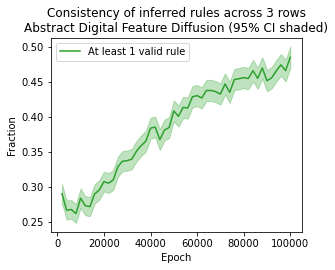

In [114]:
plt.figure(figsize=(4.5, 3.5))
CI_low, CI_high = estimate_CI((consistent_vec_all!=0).sum(axis=1), 4096, alpha=0.05)
shaded_error(plt.gca(), epoch_list, (consistent_vec_all!=0).mean(axis=1),
                CI_low, CI_high, label="At least 1 valid rule", color="C2")
plt.legend()
plt.ylabel("Fraction")
plt.xlabel("Epoch")
plt.title("Consistency of inferred rules across 3 rows\nAbstract Digital Feature Diffusion (95% CI shaded)")
plt.savefig("../Figures/RAVEN10_abstract_rule_validity.png", dpi=300)
plt.savefig("../Figures/RAVEN10_abstract_rule_validity.pdf", dpi=300)
plt.show()

### Inference per Pattern completion

In [178]:
iclass = 20
isample = 0
attr_list_row, pos_row = get_obj_list(train_inputs[iclass, isample])
rule = get_rule_list(attr_list_row, pos_row)
print(rule)
rule_img = get_rule_img(train_data2attr_tsr(train_inputs[iclass, isample]))
print(rule_img)
rule_img2 = get_rule_img(load_PGM_abstract(train_inputs[iclass, isample]))
print(rule_img2)

24
[24]
[24]


In [183]:
iclass = 2
attr_tsr = train_data2attr_tsr(train_inputs[iclass, :5])
attr_mtg = einops.rearrange(attr_tsr, "b c h w -> c (b h) w")
get_rule_img(attr_mtg)

array([4, 4, 4, 4, 4])

### inpainting loop

In [185]:
@torch.no_grad()
def edm_sampler_inpaint(
    edm, latents, target_img, mask, class_labels=None,
    num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    use_ema=True, fixed_noise=False
):
    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, edm.sigma_min)
    sigma_max = min(sigma_max, edm.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([edm.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0
    initial_noise = torch.randn_like(latents)
    # Main sampling loop.
    x_next = latents.to(torch.float64) * t_steps[0]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        # x_hat = x_next
        t_hat = t_cur
        noise_perturb = initial_noise if fixed_noise else torch.randn_like(target_img)
        x_hat = (1 - mask[None, None]) * (target_img + noise_perturb * t_cur) + \
                     mask[None, None]  * x_next
        # Euler step.
        denoised = edm(x_hat, t_hat, class_labels, use_ema=use_ema).to(torch.float64)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur

        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = edm(x_next, t_next, class_labels, use_ema=use_ema).to(torch.float64)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)

    return x_next

In [ ]:
idxs = [3,4,5]
attr_tsr = train_data2attr_tsr(train_inputs[iclass, idxs])
attr_mtg = einops.rearrange(attr_tsr, "b c h w -> c (b h) w")
orig_rules = get_rule_img(attr_mtg)
assert len(np.unique(orig_rules)) == 1
assert np.all(orig_rules != -1)
orig_rule_id = np.unique(orig_rules)[0] # note this id can be different from iclass
x_pos, y_pos = 1, 1
total_steps = 40
target_img = (attr_mtg.float().to(device) - Xmean) / Xstd
mask_tsr = torch.zeros(target_img.shape[-2:], device=device)
mask_tsr[3*x_pos:3*(x_pos+1), 3*y_pos:3*(y_pos+1)] = 1
latents = torch.randn(200, 3, 9, 9).to(device)
samples = edm_sampler_inpaint(edm, latents, target_img=target_img, mask=mask_tsr,
                                num_steps=total_steps, use_ema=False,
                                fixed_noise=True).detach()
# samples = edm_sampler(edm, latents, num_steps=num_steps)
samples = samples * Xstd + Xmean
samples_int = torch.round(samples).long().cpu()

rules_mat = []
for attr_mtg_inpaint in samples_int:
    rules = get_rule_img(attr_mtg_inpaint)
    rules_mat.append(rules)
rules_mat = np.asarray(rules_mat)
print(f"steps{num_steps} pos recovery rate {x_pos}, {y_pos} ", (rules_mat[:, x_pos]==orig_rule_id).mean(),
    "valid rate ", (rules_mat[:, x_pos]!=-1).mean())

In [234]:
idxs = [3,4,5]
attr_tsr = train_data2attr_tsr(train_inputs[iclass, idxs])
attr_mtg = einops.rearrange(attr_tsr, "b c h w -> c (b h) w")
orig_rules = get_rule_img(attr_mtg)
assert len(np.unique(orig_rules)) == 1
assert np.all(orig_rules != -1)
orig_rule_id = np.unique(orig_rules)[0] # note this id can be different from iclass
x_pos, y_pos = 1, 1
total_steps = 40
stats_col = {}
print (f"Original panels {idxs} (class id{iclass})")
print (f"Original rule id {orig_rule_id} ")
for total_steps in [10, 20, 30, 40, 80]:
    for x_pos in range(3):
        for y_pos in range(3):
            target_img = (attr_mtg.float().to(device) - Xmean) / Xstd
            mask_tsr = torch.zeros(target_img.shape[-2:], device=device)
            mask_tsr[3*x_pos:3*(x_pos+1), 3*y_pos:3*(y_pos+1)] = 1
            latents = torch.randn(1024, 3, 9, 9).to(device)
            samples = edm_sampler_inpaint(edm, latents, target_img=target_img, mask=mask_tsr,
                                            num_steps=total_steps, use_ema=False,
                                            fixed_noise=True).detach()
            samples = samples * Xstd + Xmean
            samples_int = torch.round(samples).long().cpu()

            rules_mat = []
            for attr_mtg_inpaint in samples_int:
                rules = get_rule_img(attr_mtg_inpaint)
                rules_mat.append(rules)
            rules_mat = np.asarray(rules_mat)
            print(f"steps{total_steps} pos ({x_pos}, {y_pos}) | Consistent rate %.3f" % (rules_mat[:, x_pos]==orig_rule_id).mean(),
                "valid rate %.3f" % (rules_mat[:, x_pos]!=-1).mean())
            stats_col[(total_steps, x_pos, y_pos)] = (rules_mat, (rules_mat[:, x_pos]==orig_rule_id).mean(), (rules_mat[:, x_pos]!=-1).mean())

Original panels [3, 4, 5] (class id2)
Original rule id 4 
steps10 pos (0, 0) | Consistent rate 0.329 valid rate 0.392
steps10 pos (0, 1) | Consistent rate 0.530 valid rate 0.606
steps10 pos (0, 2) | Consistent rate 0.251 valid rate 0.337
steps10 pos (1, 0) | Consistent rate 0.323 valid rate 0.326
steps10 pos (1, 1) | Consistent rate 0.374 valid rate 0.376
steps10 pos (1, 2) | Consistent rate 0.369 valid rate 0.377
steps10 pos (2, 0) | Consistent rate 0.232 valid rate 0.235
steps10 pos (2, 1) | Consistent rate 0.506 valid rate 0.508
steps10 pos (2, 2) | Consistent rate 0.186 valid rate 0.268
steps20 pos (0, 0) | Consistent rate 0.436 valid rate 0.496
steps20 pos (0, 1) | Consistent rate 0.669 valid rate 0.716
steps20 pos (0, 2) | Consistent rate 0.354 valid rate 0.437
steps20 pos (1, 0) | Consistent rate 0.479 valid rate 0.480
steps20 pos (1, 1) | Consistent rate 0.518 valid rate 0.518
steps20 pos (1, 2) | Consistent rate 0.461 valid rate 0.465
steps20 pos (2, 0) | Consistent rate 0.264

In [235]:
idxs = [3,4,5]
attr_tsr = train_data2attr_tsr(train_inputs[iclass, idxs])
attr_mtg = einops.rearrange(attr_tsr, "b c h w -> c (b h) w")
orig_rules = get_rule_img(attr_mtg)
assert len(np.unique(orig_rules)) == 1
assert np.all(orig_rules != -1)
orig_rule_id = np.unique(orig_rules)[0] # note this id can be different from iclass
x_pos, y_pos = 1, 1
total_steps = 40
stats_col = {}
print (f"Original panels {idxs} (class id {iclass})")
print (f"Original rule id {orig_rule_id} ")
print("non fixed noise stochastic inpainting")
for total_steps in [10, 20, 30, 40, 80]:
    for x_pos in range(3):
        for y_pos in range(3):
            target_img = (attr_mtg.float().to(device) - Xmean) / Xstd
            mask_tsr = torch.zeros(target_img.shape[-2:], device=device)
            mask_tsr[3*x_pos:3*(x_pos+1), 3*y_pos:3*(y_pos+1)] = 1
            latents = torch.randn(1024, 3, 9, 9).to(device)
            samples = edm_sampler_inpaint(edm, latents, target_img=target_img, mask=mask_tsr,
                                            num_steps=total_steps, use_ema=False,
                                            fixed_noise=False).detach()
            samples = samples * Xstd + Xmean
            samples_int = torch.round(samples).long().cpu()

            rules_mat = []
            for attr_mtg_inpaint in samples_int:
                rules = get_rule_img(attr_mtg_inpaint)
                rules_mat.append(rules)
            rules_mat = np.asarray(rules_mat)
            print(f"steps{total_steps} pos ({x_pos}, {y_pos}) | Consistent rate %.3f" % (rules_mat[:, x_pos]==orig_rule_id).mean(),
                "valid rate %.3f" % (rules_mat[:, x_pos]!=-1).mean())
            stats_col[(total_steps, x_pos, y_pos)] = (rules_mat, (rules_mat[:, x_pos]==orig_rule_id).mean(), (rules_mat[:, x_pos]!=-1).mean())

Original panels [3, 4, 5] (class id 2)
Original rule id 4 
non fixed noise stochastic inpainting
steps10 pos (0, 0) | Consistent rate 0.496 valid rate 0.538
steps10 pos (0, 1) | Consistent rate 0.646 valid rate 0.694
steps10 pos (0, 2) | Consistent rate 0.187 valid rate 0.285
steps10 pos (1, 0) | Consistent rate 0.544 valid rate 0.544
steps10 pos (1, 1) | Consistent rate 0.365 valid rate 0.366
steps10 pos (1, 2) | Consistent rate 0.382 valid rate 0.385
steps10 pos (2, 0) | Consistent rate 0.188 valid rate 0.190
steps10 pos (2, 1) | Consistent rate 0.405 valid rate 0.408
steps10 pos (2, 2) | Consistent rate 0.315 valid rate 0.374
steps20 pos (0, 0) | Consistent rate 0.490 valid rate 0.531
steps20 pos (0, 1) | Consistent rate 0.689 valid rate 0.717
steps20 pos (0, 2) | Consistent rate 0.338 valid rate 0.407
steps20 pos (1, 0) | Consistent rate 0.455 valid rate 0.457
steps20 pos (1, 1) | Consistent rate 0.517 valid rate 0.517
steps20 pos (1, 2) | Consistent rate 0.409 valid rate 0.418
ste

In [239]:
iclass = 10
idxs = [3,4,5]
attr_tsr = train_data2attr_tsr(train_inputs[iclass, idxs])
attr_mtg = einops.rearrange(attr_tsr, "b c h w -> c (b h) w")
orig_rules = get_rule_img(attr_mtg)
assert len(np.unique(orig_rules)) == 1
assert np.all(orig_rules != -1)
orig_rule_id = np.unique(orig_rules)[0] # note this id can be different from iclass
x_pos, y_pos = 1, 1
total_steps = 40
stats_col = {}
print (f"Original panels {idxs} (class id {iclass})")
print (f"Original rule id {orig_rule_id} ")
print("non fixed noise stochastic inpainting")
for total_steps in [10, 20, 30, 40, 80]:
    for x_pos in range(3):
        for y_pos in range(3):
            target_img = (attr_mtg.float().to(device) - Xmean) / Xstd
            mask_tsr = torch.zeros(target_img.shape[-2:], device=device)
            mask_tsr[3*x_pos:3*(x_pos+1), 3*y_pos:3*(y_pos+1)] = 1
            latents = torch.randn(1024, 3, 9, 9).to(device)
            samples = edm_sampler_inpaint(edm, latents, target_img=target_img, mask=mask_tsr,
                                            num_steps=total_steps, use_ema=False,
                                            fixed_noise=False).detach()
            samples = samples * Xstd + Xmean
            samples_int = torch.round(samples).long().cpu()

            rules_mat = []
            for attr_mtg_inpaint in samples_int:
                rules = get_rule_img(attr_mtg_inpaint)
                rules_mat.append(rules)
            rules_mat = np.asarray(rules_mat)
            print(f"steps{total_steps} pos ({x_pos}, {y_pos}) | Consistent rate %.3f" % (rules_mat[:, x_pos]==orig_rule_id).mean(),
                "valid rate %.3f" % (rules_mat[:, x_pos]!=-1).mean())
            stats_col[(total_steps, x_pos, y_pos)] = (rules_mat, (rules_mat[:, x_pos]==orig_rule_id).mean(), (rules_mat[:, x_pos]!=-1).mean())

Original panels [3, 4, 5] (class id 10)
Original rule id 12 
non fixed noise stochastic inpainting
steps10 pos (0, 0) | Consistent rate 0.200 valid rate 0.310
steps10 pos (0, 1) | Consistent rate 0.224 valid rate 0.378
steps10 pos (0, 2) | Consistent rate 0.083 valid rate 0.258
steps10 pos (1, 0) | Consistent rate 0.249 valid rate 0.275
steps10 pos (1, 1) | Consistent rate 0.240 valid rate 0.352
steps10 pos (1, 2) | Consistent rate 0.179 valid rate 0.227
steps10 pos (2, 0) | Consistent rate 0.152 valid rate 0.178
steps10 pos (2, 1) | Consistent rate 0.131 valid rate 0.264
steps10 pos (2, 2) | Consistent rate 0.093 valid rate 0.185
steps20 pos (0, 0) | Consistent rate 0.145 valid rate 0.263
steps20 pos (0, 1) | Consistent rate 0.271 valid rate 0.396
steps20 pos (0, 2) | Consistent rate 0.165 valid rate 0.330
steps20 pos (1, 0) | Consistent rate 0.155 valid rate 0.219
steps20 pos (1, 1) | Consistent rate 0.275 valid rate 0.384
steps20 pos (1, 2) | Consistent rate 0.215 valid rate 0.273
s

In [240]:
iclass = 20
idxs = [3,4,5]
attr_tsr = train_data2attr_tsr(train_inputs[iclass, idxs])
attr_mtg = einops.rearrange(attr_tsr, "b c h w -> c (b h) w")
orig_rules = get_rule_img(attr_mtg)
assert len(np.unique(orig_rules)) == 1
assert np.all(orig_rules != -1)
orig_rule_id = np.unique(orig_rules)[0] # note this id can be different from iclass
x_pos, y_pos = 1, 1
total_steps = 40
stats_col = {}
print (f"Original panels {idxs} (class id {iclass})")
print (f"Original rule id {orig_rule_id} ")
print("non fixed noise stochastic inpainting")
for total_steps in [10, 20, 30, 40, 80]:
    for x_pos in range(3):
        for y_pos in range(3):
            target_img = (attr_mtg.float().to(device) - Xmean) / Xstd
            mask_tsr = torch.zeros(target_img.shape[-2:], device=device)
            mask_tsr[3*x_pos:3*(x_pos+1), 3*y_pos:3*(y_pos+1)] = 1
            latents = torch.randn(1024, 3, 9, 9).to(device)
            samples = edm_sampler_inpaint(edm, latents, target_img=target_img, mask=mask_tsr,
                                            num_steps=total_steps, use_ema=False,
                                            fixed_noise=False).detach()
            samples = samples * Xstd + Xmean
            samples_int = torch.round(samples).long().cpu()

            rules_mat = []
            for attr_mtg_inpaint in samples_int:
                rules = get_rule_img(attr_mtg_inpaint)
                rules_mat.append(rules)
            rules_mat = np.asarray(rules_mat)
            print(f"steps{total_steps} pos ({x_pos}, {y_pos}) | Consistent rate %.3f" % (rules_mat[:, x_pos]==orig_rule_id).mean(),
                "valid rate %.3f" % (rules_mat[:, x_pos]!=-1).mean())
            stats_col[(total_steps, x_pos, y_pos)] = (rules_mat, (rules_mat[:, x_pos]==orig_rule_id).mean(), (rules_mat[:, x_pos]!=-1).mean())
            
figh, axh = plt.subplots(1, 5, figsize=(20, 4))
for i, total_steps in enumerate([10, 20, 30, 40, 80]):
    plt.sca(axh[i])
    acc_mat = np.array([[stats_col[total_steps, x_pos, y_pos][1] for y_pos in range(3)] for x_pos in range(3)])
    sns.heatmap(acc_mat, annot=True, cmap="YlGnBu", cbar=False, ax=axh[i])
    axh[i].set_xlabel("x pos")
    axh[i].set_ylabel("y pos")
    plt.axis("equal")
    axh[i].set_title(f"steps {total_steps}")
    
plt.suptitle("Consistency rate of inferred rules\nAbstract Digital Feature Diffusion")
plt.show()

Original panels [3, 4, 5] (class id 20)
Original rule id 24 
non fixed noise stochastic inpainting
steps10 pos (0, 0) | Consistent rate 0.166 valid rate 0.253
steps10 pos (0, 1) | Consistent rate 0.206 valid rate 0.362
steps10 pos (0, 2) | Consistent rate 0.043 valid rate 0.058
steps10 pos (1, 0) | Consistent rate 0.203 valid rate 0.238
steps10 pos (1, 1) | Consistent rate 0.327 valid rate 0.439
steps10 pos (1, 2) | Consistent rate 0.034 valid rate 0.056
steps10 pos (2, 0) | Consistent rate 0.067 valid rate 0.072
steps10 pos (2, 1) | Consistent rate 0.135 valid rate 0.139
steps10 pos (2, 2) | Consistent rate 0.057 valid rate 0.149
steps20 pos (0, 0) | Consistent rate 0.325 valid rate 0.388
steps20 pos (0, 1) | Consistent rate 0.349 valid rate 0.461
steps20 pos (0, 2) | Consistent rate 0.043 valid rate 0.075
steps20 pos (1, 0) | Consistent rate 0.267 valid rate 0.312
steps20 pos (1, 1) | Consistent rate 0.234 valid rate 0.364
steps20 pos (1, 2) | Consistent rate 0.058 valid rate 0.073
s

Original panels [0, 1, 2] (class id 0)
Original rule id 1 
non fixed noise stochastic inpainting


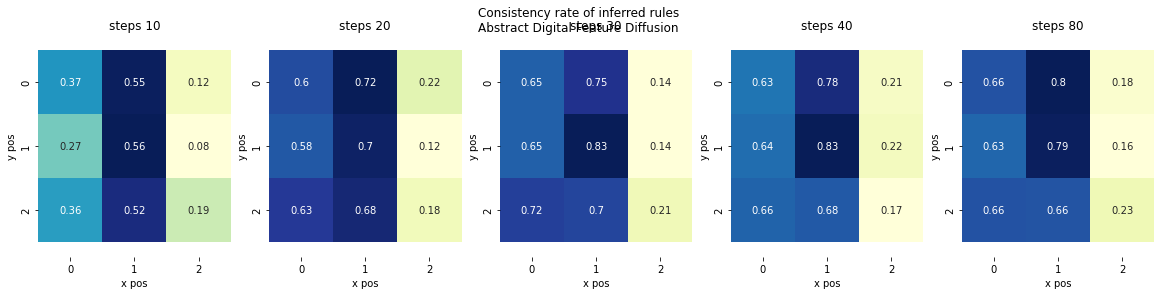

Original panels [0, 1, 2] (class id 1)
Original rule id 3 
non fixed noise stochastic inpainting


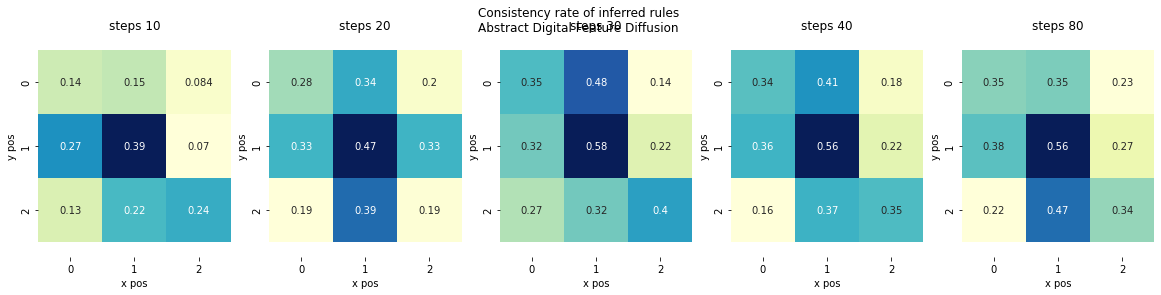

Original panels [0, 1, 2] (class id 2)
Original rule id 4 
non fixed noise stochastic inpainting


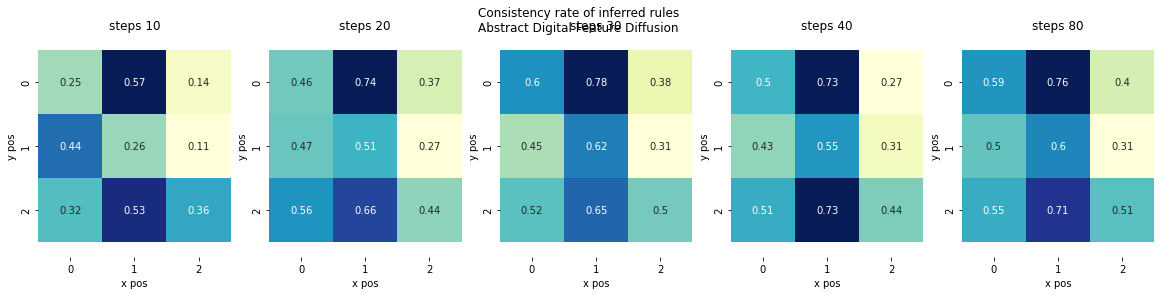

Class 3 has no valid rule, skip
Class 4 has no valid rule, skip
Original panels [0, 1, 2] (class id 5)
Original rule id 7 
non fixed noise stochastic inpainting


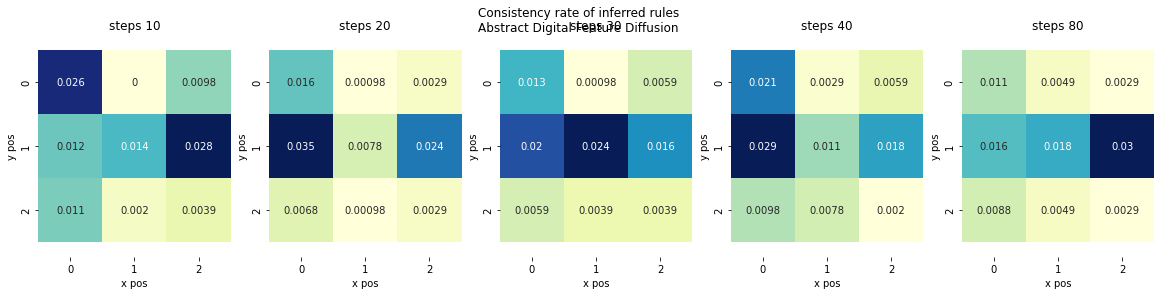

Class 6 has no valid rule, skip
Original panels [0, 1, 2] (class id 7)
Original rule id 9 
non fixed noise stochastic inpainting


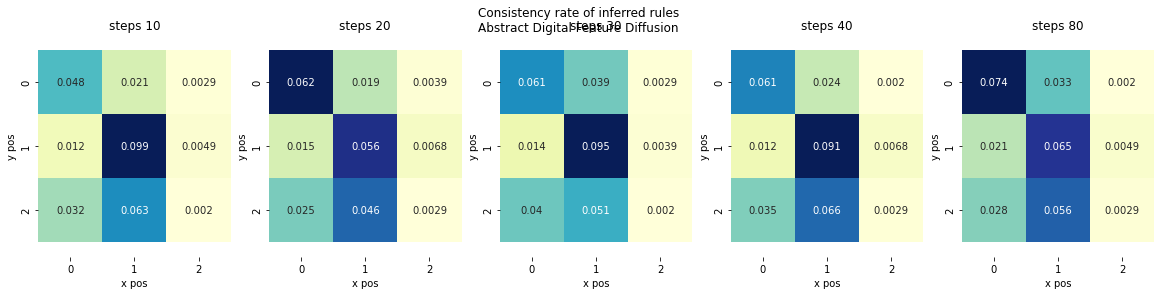

Original panels [0, 1, 2] (class id 8)
Original rule id 10 
non fixed noise stochastic inpainting


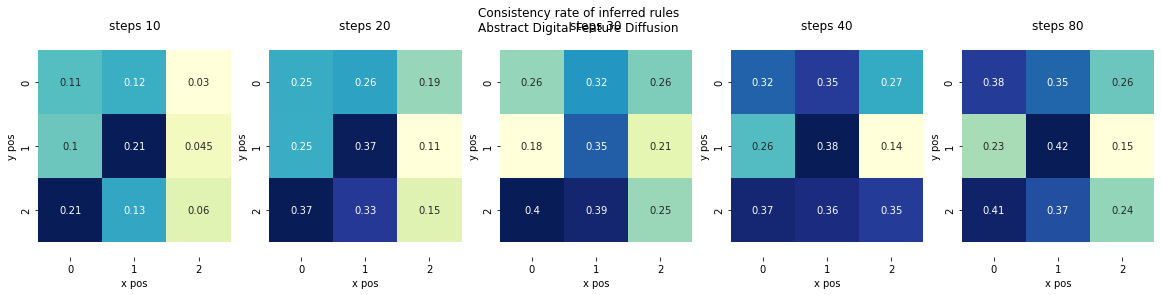

Original panels [0, 1, 2] (class id 9)
Original rule id 11 
non fixed noise stochastic inpainting


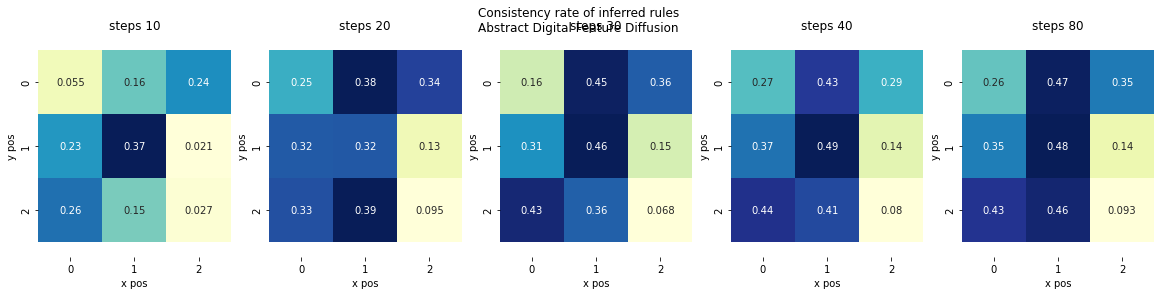

Original panels [0, 1, 2] (class id 10)
Original rule id 12 
non fixed noise stochastic inpainting


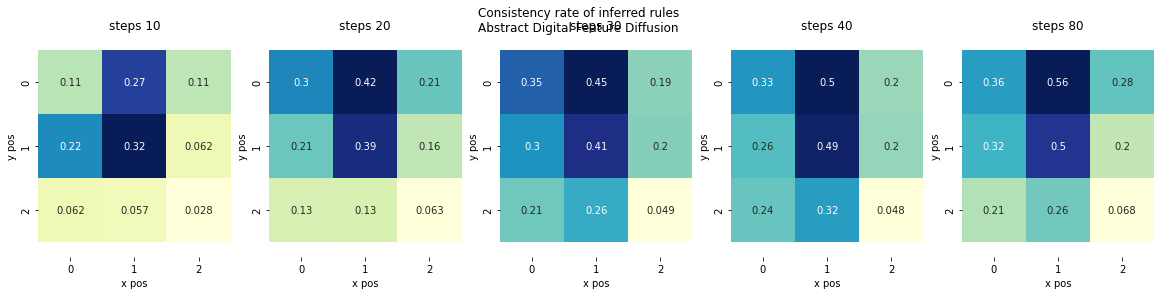

Original panels [0, 1, 2] (class id 11)
Original rule id 14 
non fixed noise stochastic inpainting


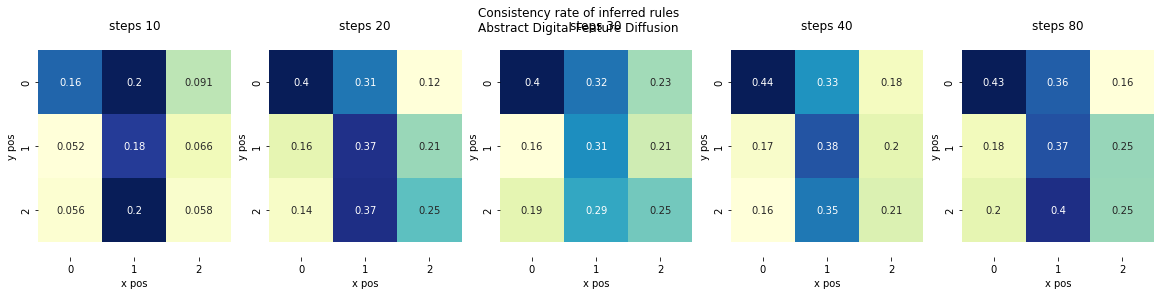

Class 12 has no valid rule, skip
Class 13 has no valid rule, skip
Original panels [0, 1, 2] (class id 14)
Original rule id 17 
non fixed noise stochastic inpainting


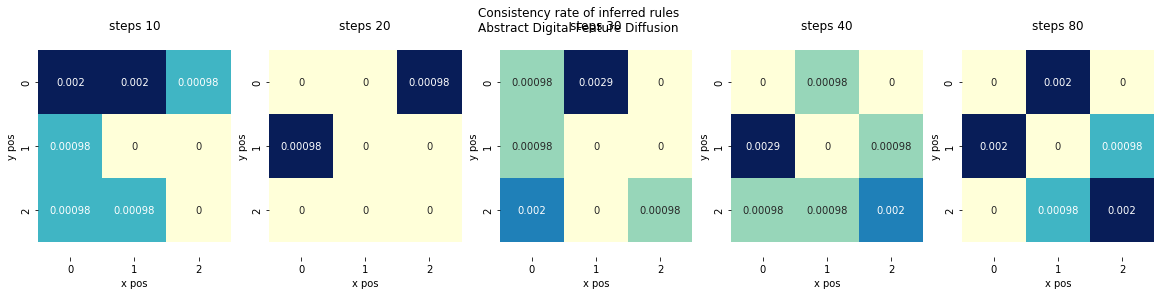

Class 15 has no valid rule, skip
Original panels [0, 1, 2] (class id 16)
Original rule id 19 
non fixed noise stochastic inpainting


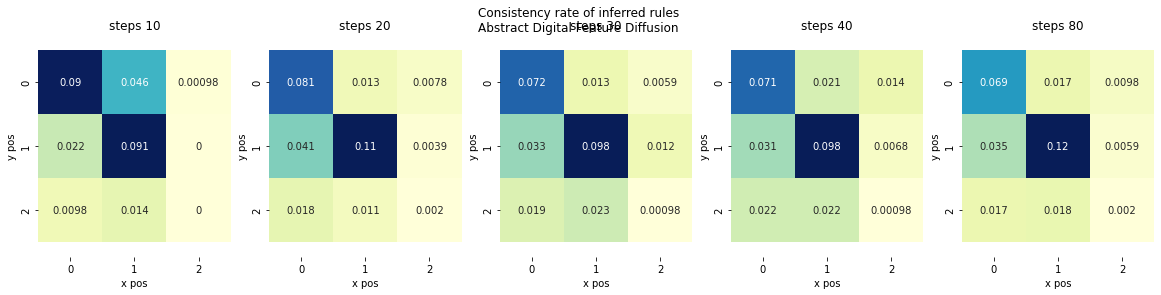

Original panels [0, 1, 2] (class id 17)
Original rule id 21 
non fixed noise stochastic inpainting


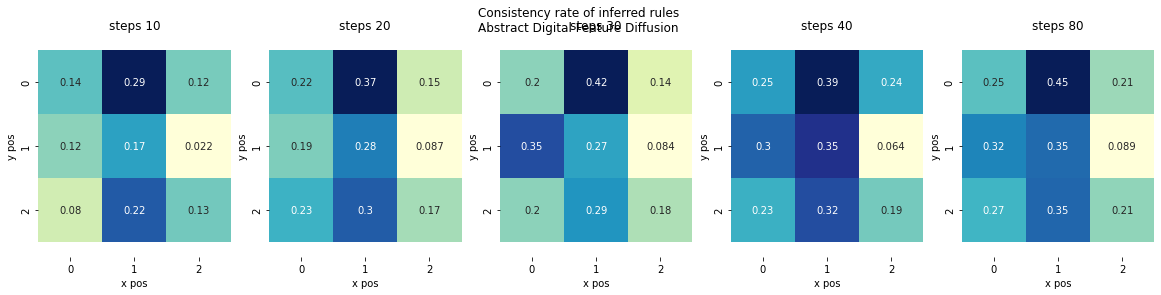

Original panels [0, 1, 2] (class id 18)
Original rule id 22 
non fixed noise stochastic inpainting


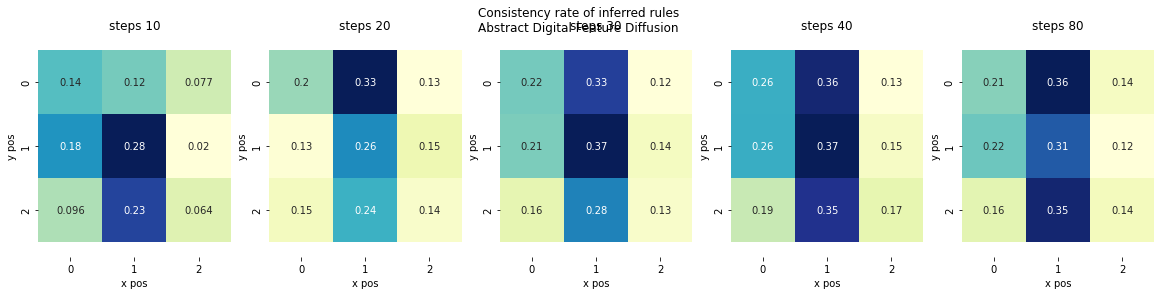

Original panels [0, 1, 2] (class id 19)
Original rule id 23 
non fixed noise stochastic inpainting


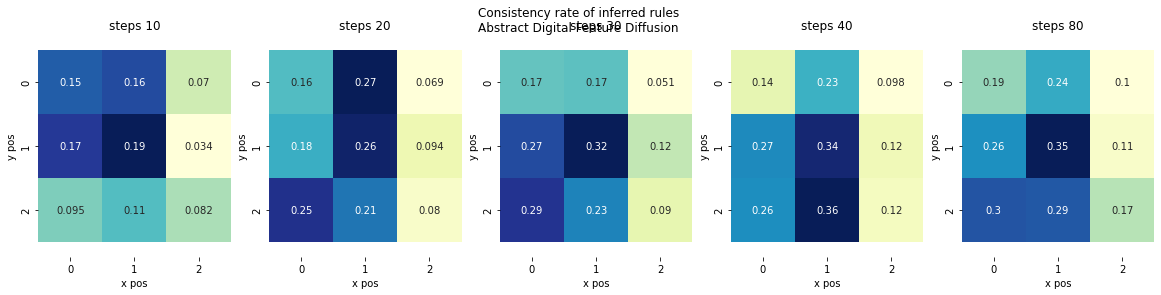

Original panels [0, 1, 2] (class id 20)
Original rule id 24 
non fixed noise stochastic inpainting


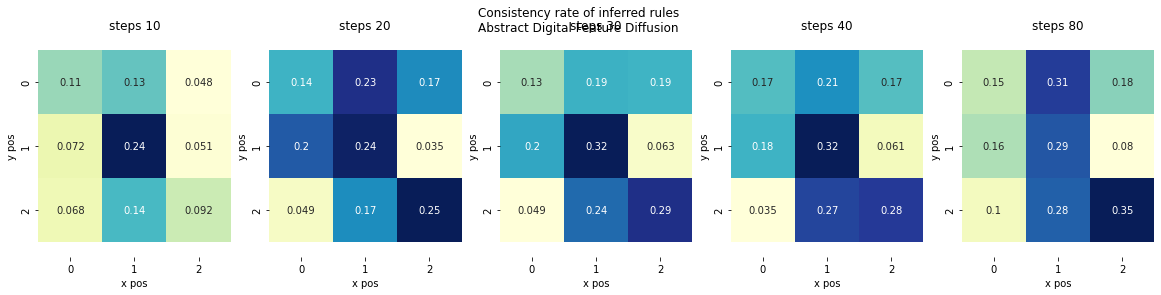

Class 21 has no valid rule, skip
Class 22 has no valid rule, skip
Original panels [0, 1, 2] (class id 23)
Original rule id 27 
non fixed noise stochastic inpainting


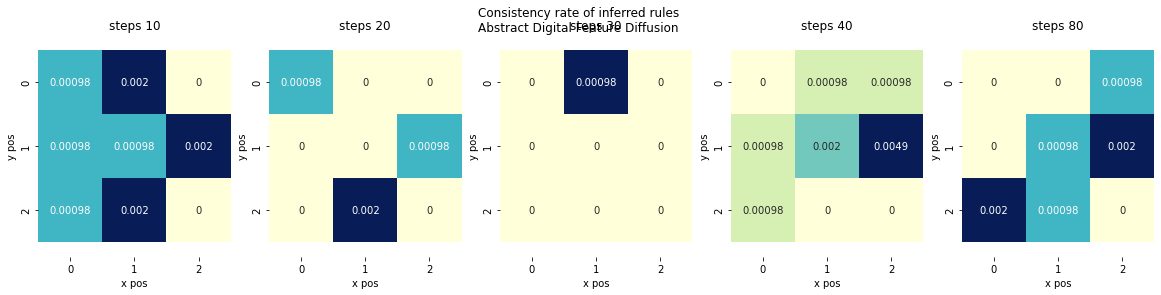

Class 24 has no valid rule, skip
Original panels [0, 1, 2] (class id 25)
Original rule id 29 
non fixed noise stochastic inpainting


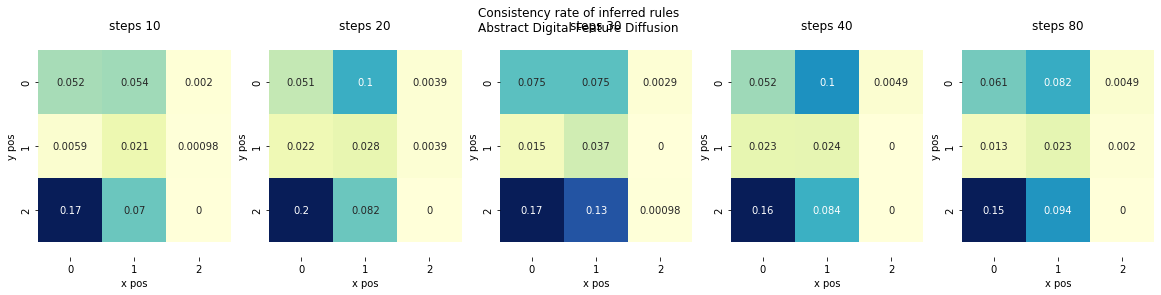

Original panels [0, 1, 2] (class id 26)
Original rule id 30 
non fixed noise stochastic inpainting


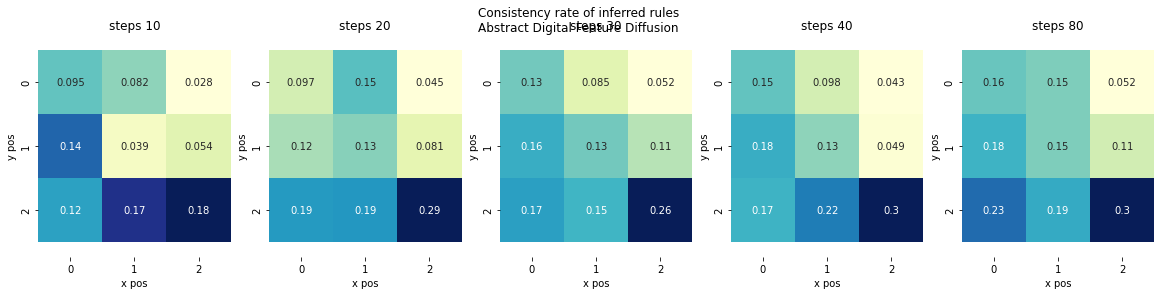

Class 27 has no valid rule, skip
Original panels [0, 1, 2] (class id 28)
Original rule id 32 
non fixed noise stochastic inpainting


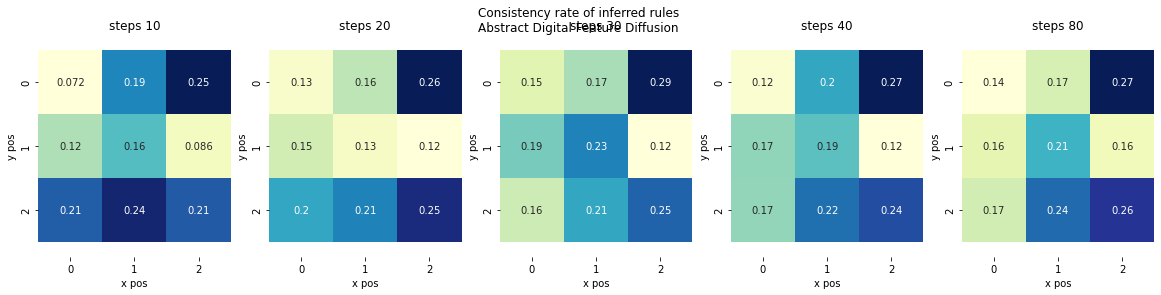

Original panels [0, 1, 2] (class id 29)
Original rule id 33 
non fixed noise stochastic inpainting


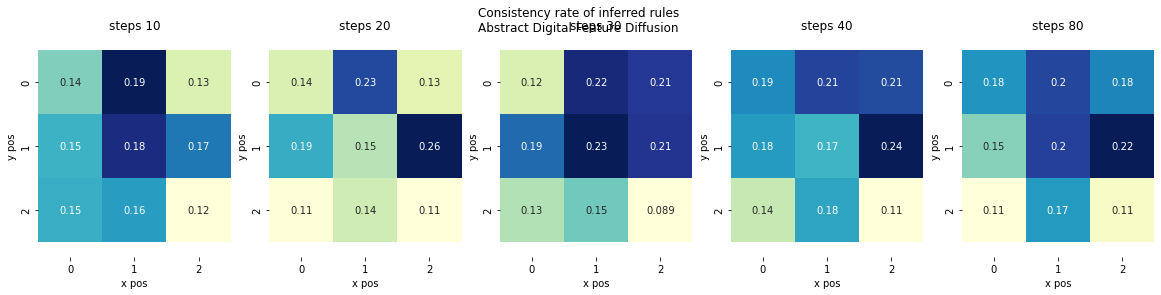

Original panels [0, 1, 2] (class id 30)
Original rule id 34 
non fixed noise stochastic inpainting


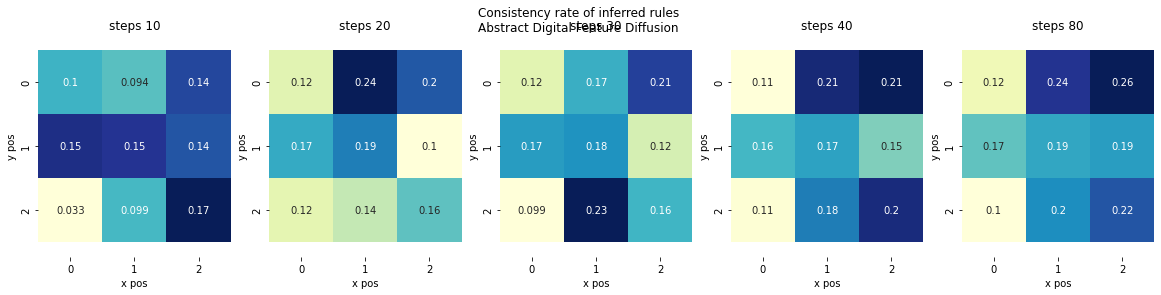

Class 31 has no valid rule, skip
Class 32 has no valid rule, skip
Class 33 has no valid rule, skip
Class 34 has no valid rule, skip


In [248]:
import os
os.makedirs("../Figures/inpainting", exist_ok=True)
import pickle as pkl
idxs = [0,1,2]
for iclass in range(35):
    try:
        attr_tsr = train_data2attr_tsr(train_inputs[iclass, idxs])
        attr_mtg = einops.rearrange(attr_tsr, "b c h w -> c (b h) w")
        orig_rules = get_rule_img(attr_mtg)
        assert len(np.unique(orig_rules)) == 1
        assert np.all(orig_rules != -1)
        orig_rule_id = np.unique(orig_rules)[0] # note this id can be different from iclass
        x_pos, y_pos = 1, 1
        total_steps = 40
        stats_col = {}
        print (f"Original panels {idxs} (class id {iclass})")
        print (f"Original rule id {orig_rule_id} ")
        print("non fixed noise stochastic inpainting")
        for total_steps in [10, 20, 30, 40, 80]:
            for x_pos in range(3):
                for y_pos in range(3):
                    target_img = (attr_mtg.float().to(device) - Xmean) / Xstd
                    mask_tsr = torch.zeros(target_img.shape[-2:], device=device)
                    mask_tsr[3*x_pos:3*(x_pos+1), 3*y_pos:3*(y_pos+1)] = 1
                    latents = torch.randn(1024, 3, 9, 9).to(device)
                    samples = edm_sampler_inpaint(edm, latents, target_img=target_img, mask=mask_tsr,
                                                    num_steps=total_steps, use_ema=False,
                                                    fixed_noise=False).detach()
                    samples = samples * Xstd + Xmean
                    samples_int = torch.round(samples).long().cpu()

                    rules_mat = []
                    for attr_mtg_inpaint in samples_int:
                        rules = get_rule_img(attr_mtg_inpaint)
                        rules_mat.append(rules)
                    rules_mat = np.asarray(rules_mat)
                    # print(f"steps{total_steps} pos ({x_pos}, {y_pos}) | Consistent rate %.3f" % (rules_mat[:, x_pos]==orig_rule_id).mean(),
                    #     "valid rate %.3f" % (rules_mat[:, x_pos]!=-1).mean())
                    stats_col[(total_steps, x_pos, y_pos)] = (rules_mat, (rules_mat[:, x_pos]==orig_rule_id).mean(), (rules_mat[:, x_pos]!=-1).mean())

        pkl.dump(stats_col, open(f"../Figures/inpainting/RAVEN10_abstract_inpainting_rule_consistency_class{iclass}.pkl", "wb"))                    

        figh, axh = plt.subplots(1, 5, figsize=(20, 4))
        for i, total_steps in enumerate([10, 20, 30, 40, 80]):
            plt.sca(axh[i])
            acc_mat = np.array([[stats_col[total_steps, x_pos, y_pos][1] for y_pos in range(3)] for x_pos in range(3)])
            sns.heatmap(acc_mat, annot=True, cmap="YlGnBu", cbar=False, ax=axh[i])
            axh[i].set_xlabel("x pos")
            axh[i].set_ylabel("y pos")
            plt.axis("equal")
            axh[i].set_title(f"steps {total_steps}")
            
        plt.suptitle("Consistency rate of inferred rules\nAbstract Digital Feature Diffusion")
        plt.savefig(f"../Figures/inpainting/RAVEN10_abstract_inpainting_rule_consistency_class{iclass}.png", dpi=300)
        plt.savefig(f"../Figures/inpainting/RAVEN10_abstract_inpainting_rule_consistency_class{iclass}.pdf", dpi=300)
        plt.show()
    except AssertionError:
        print(f"Class {iclass} has no valid rule, skip")
        continue

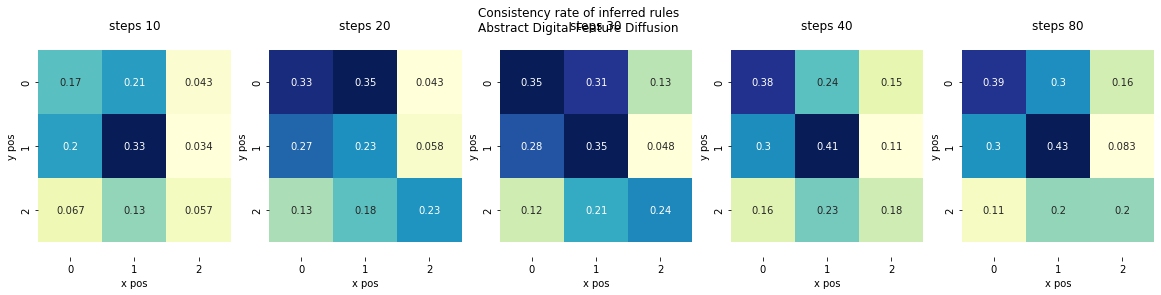

In [245]:
import seaborn as sns
figh, axh = plt.subplots(1, 5, figsize=(20, 4))
for i, total_steps in enumerate([10, 20, 30, 40, 80]):
    plt.sca(axh[i])
    acc_mat = np.array([[stats_col[total_steps, x_pos, y_pos][1] for y_pos in range(3)] for x_pos in range(3)])
    sns.heatmap(acc_mat, annot=True, cmap="YlGnBu", cbar=False, ax=axh[i])
    axh[i].set_xlabel("x pos")
    axh[i].set_ylabel("y pos")
    plt.axis("equal")
    axh[i].set_title(f"steps {total_steps}")
    
plt.suptitle("Consistency rate of inferred rules\nAbstract Digital Feature Diffusion")
plt.show()

### Wide Abstract Encoding

In [11]:
device = "cuda"
Xmean = torch.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to(device)
Xstd = torch.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to(device)

In [12]:
DATASET="RAVEN10_abstract"
config_ft = get_default_config(DATASET, layers_per_block=2, model_channels=128)
epoch = 999999
ckptdir = r"/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/Wide_RAVEN10_abstract_20240206-2323/checkpoints/"
edm, model = create_edm(ckptdir + f"/ema_{epoch}.pth", config_ft, device) 

In [14]:

os.makedirs(ckptdir+"/../inpainting_figs", exist_ok=True)
figdir = ckptdir+"/../inpainting_figs"
model_str = f"Wide_abstract_ep{epoch}"
sample_size = 1024
steps2try = [10, 20, 30, 40, 80]
idxs = [0,1,2]
for iclass in range(35):
    try:
        attr_tsr = train_data2attr_tsr(train_inputs[iclass, idxs])
        attr_mtg = einops.rearrange(attr_tsr, "b c h w -> c (b h) w")
        orig_rules = get_rule_img(attr_mtg)
        assert len(np.unique(orig_rules)) == 1
        assert np.all(orig_rules != -1)
        orig_rule_id = np.unique(orig_rules)[0] # note this id can be different from iclass
        x_pos, y_pos = 1, 1
        total_steps = 40
        stats_col = {}
        print (f"Original panels {idxs} (class id {iclass})")
        print (f"Original rule id {orig_rule_id} ")
        print("non fixed noise stochastic inpainting")
        for total_steps in steps2try:
            for x_pos in range(3):
                for y_pos in range(3):
                    target_img = (attr_mtg.float().to(device) - Xmean) / Xstd
                    mask_tsr = torch.zeros(target_img.shape[-2:], device=device)
                    mask_tsr[3*x_pos:3*(x_pos+1), 3*y_pos:3*(y_pos+1)] = 1
                    latents = torch.randn(sample_size, 3, 9, 9).to(device)
                    samples = edm_sampler_inpaint(edm, latents, target_img=target_img, mask=mask_tsr,
                                                    num_steps=total_steps, use_ema=False,
                                                    fixed_noise=False).detach()
                    samples = samples * Xstd + Xmean
                    samples_int = torch.round(samples).long().cpu()

                    rules_mat = []
                    for attr_mtg_inpaint in samples_int:
                        rules = get_rule_img(attr_mtg_inpaint)
                        rules_mat.append(rules)
                    rules_mat = np.asarray(rules_mat)
                    stats_col[(total_steps, x_pos, y_pos)] = (rules_mat, 
                                                              (rules_mat[:, x_pos]==orig_rule_id).mean(), 
                                                              (rules_mat[:, x_pos]!=-1).mean())

        pkl.dump(stats_col, open(join(figdir, f"{model_str}_inpainting_rule_consistency_class{iclass}.pkl"), "wb"))                    

        figh, axh = plt.subplots(1, len(steps2try), figsize=(20, 4))
        for i, total_steps in enumerate(steps2try):
            plt.sca(axh[i])
            acc_mat = np.array([[stats_col[total_steps, x_pos, y_pos][1] for y_pos in range(3)] for x_pos in range(3)])
            sns.heatmap(acc_mat, annot=True, cmap="YlGnBu", cbar=False, ax=axh[i])
            axh[i].set_xlabel("x pos")
            axh[i].set_ylabel("y pos")
            plt.axis("equal")
            axh[i].set_title(f"steps {total_steps}")
            
        plt.suptitle("Consistency rate of inferred rules\nAbstract Digital Feature Diffusion")
        plt.savefig(join(figdir, f"{model_str}_inpainting_rule_consistency_class{iclass}.png"), dpi=300)
        plt.savefig(join(figdir, f"{model_str}_inpainting_rule_consistency_class{iclass}.pdf"), dpi=300)
        plt.show()
    except AssertionError:
        print(f"Class {iclass} has no valid rule, skip")
        continue

Original panels [0, 1, 2] (class id 0)
Original rule id 1 
non fixed noise stochastic inpainting


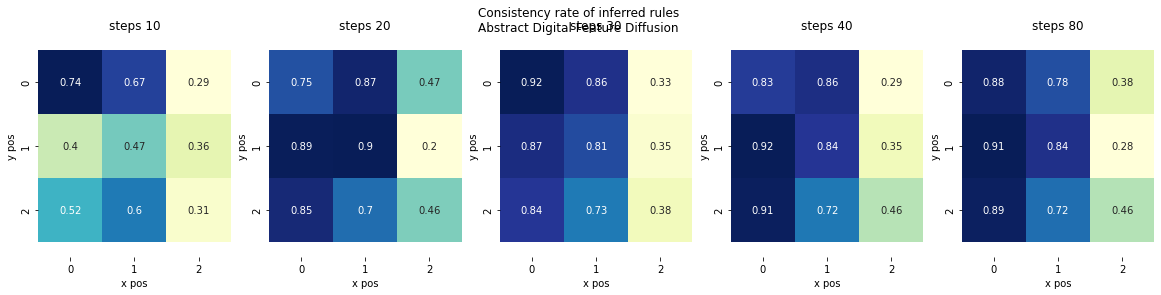

In [19]:
import seaborn as sns
figh, axh = plt.subplots(1, len(steps2try), figsize=(20, 4))
for i, total_steps in enumerate(steps2try):
    plt.sca(axh[i])
    acc_mat = np.array([[stats_col[total_steps, x_pos, y_pos][1] for y_pos in range(3)] for x_pos in range(3)])
    sns.heatmap(acc_mat, annot=True, cmap="YlGnBu", cbar=False, ax=axh[i])
    axh[i].set_xlabel("x pos")
    axh[i].set_ylabel("y pos")
    plt.axis("equal")
    axh[i].set_title(f"steps {total_steps}")
    
plt.suptitle("Consistency rate of inferred rules\nAbstract Digital Feature Diffusion")
plt.savefig(join(figdir, f"{model_str}_inpainting_rule_consistency_class{iclass}.png"), dpi=300)
plt.savefig(join(figdir, f"{model_str}_inpainting_rule_consistency_class{iclass}.pdf"), dpi=300)
plt.show()

### Big Abstract Encoding

In [7]:
device = "cuda"
Xmean = torch.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to(device)
Xstd = torch.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to(device)

In [8]:
DATASET="RAVEN10_abstract"
config_ft = get_default_config(DATASET, layers_per_block=3, model_channels=192, spatial_matching="bilinear")
epoch = 999999
ckptdir = r"/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/BigBlnr_RAVEN10_abstract_20240208-1709/checkpoints"
edm, model = create_edm(ckptdir + f"/ema_{epoch}.pth", config_ft, device) 

Original panels [0, 1, 2] (class id 0)
Original rule id 1 
non fixed noise stochastic inpainting


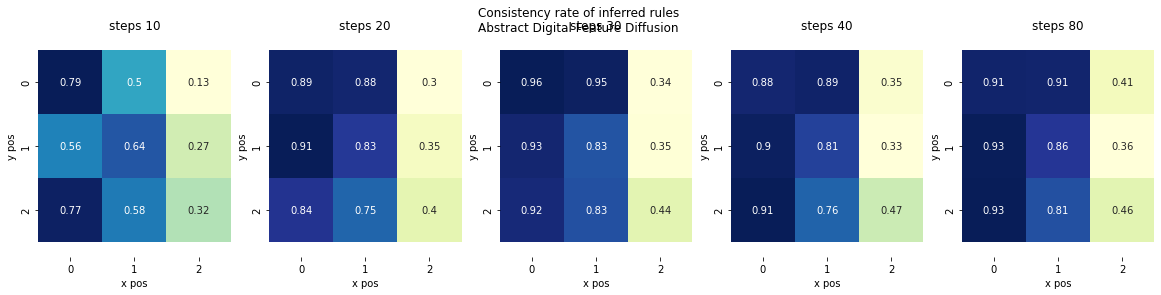

Original panels [0, 1, 2] (class id 1)
Original rule id 3 
non fixed noise stochastic inpainting


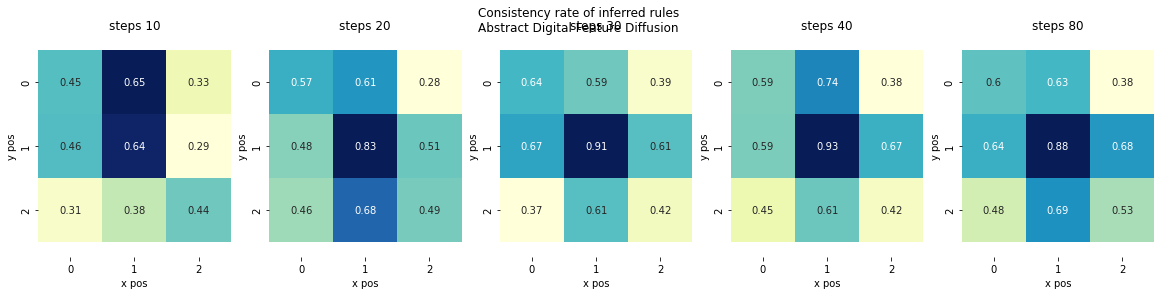

Original panels [0, 1, 2] (class id 2)
Original rule id 4 
non fixed noise stochastic inpainting


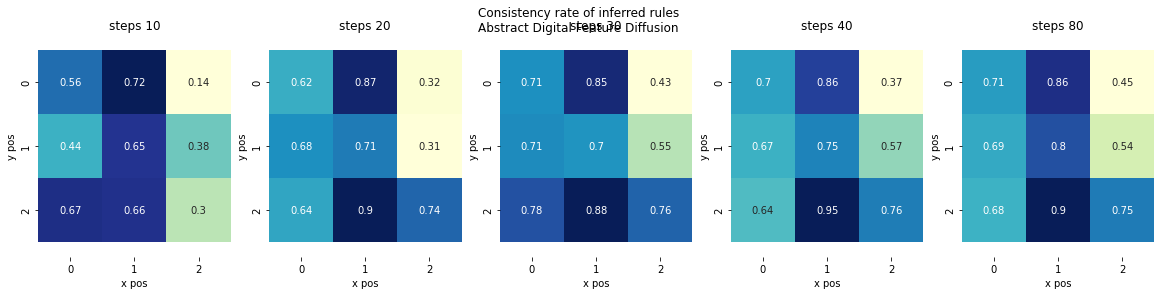

Class 3 has no valid rule, skip
Class 4 has no valid rule, skip
Original panels [0, 1, 2] (class id 5)
Original rule id 7 
non fixed noise stochastic inpainting


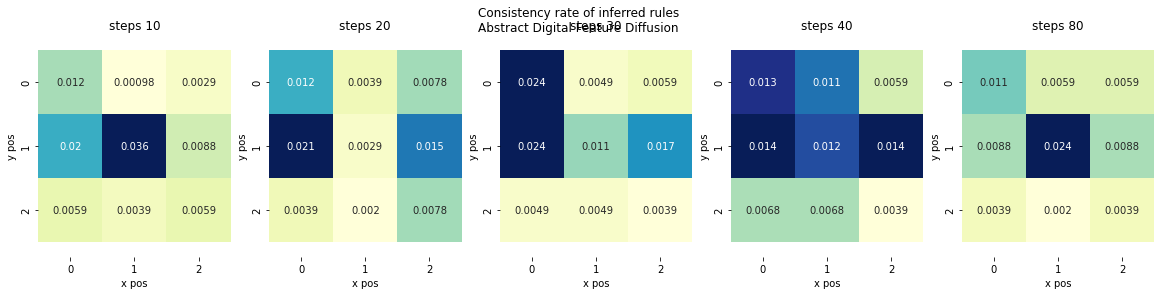

Class 6 has no valid rule, skip
Original panels [0, 1, 2] (class id 7)
Original rule id 9 
non fixed noise stochastic inpainting


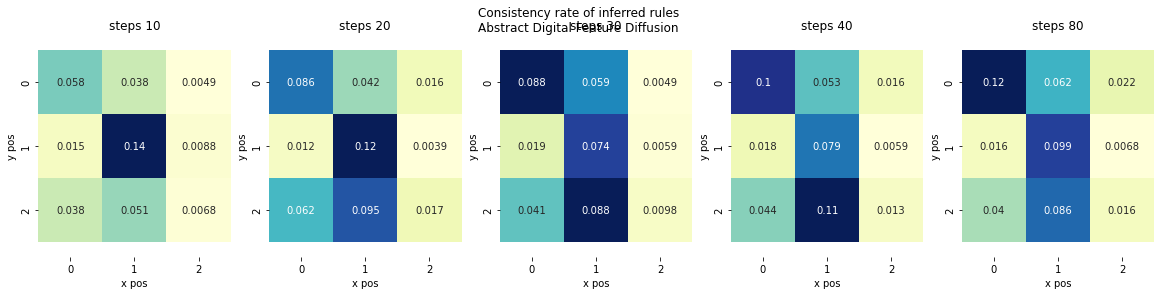

Original panels [0, 1, 2] (class id 8)
Original rule id 10 
non fixed noise stochastic inpainting


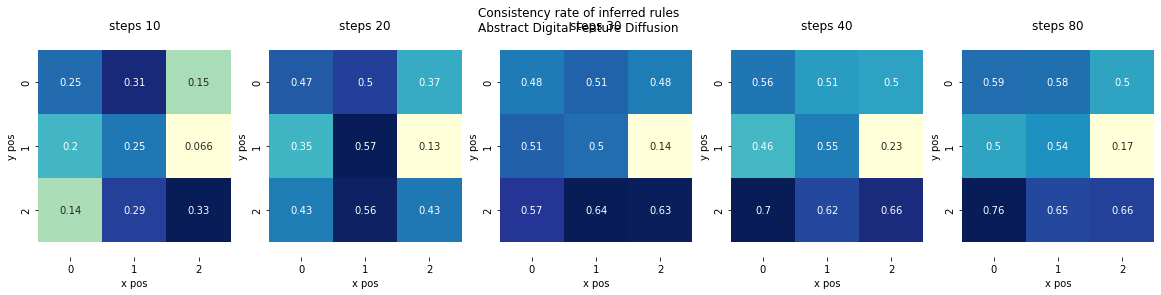

Original panels [0, 1, 2] (class id 9)
Original rule id 11 
non fixed noise stochastic inpainting


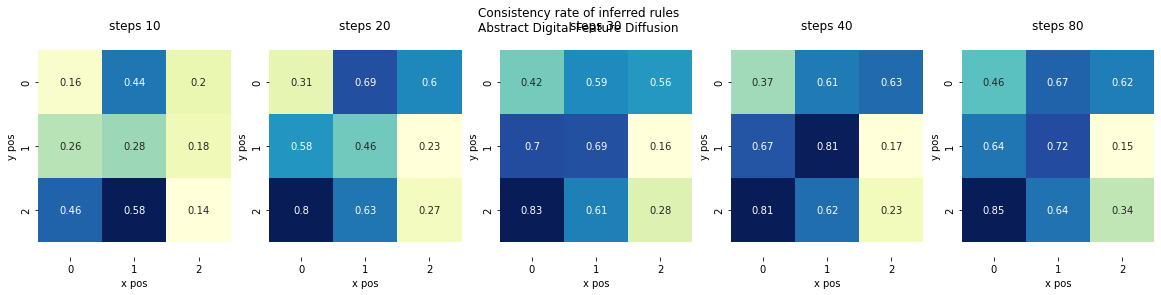

Original panels [0, 1, 2] (class id 10)
Original rule id 12 
non fixed noise stochastic inpainting


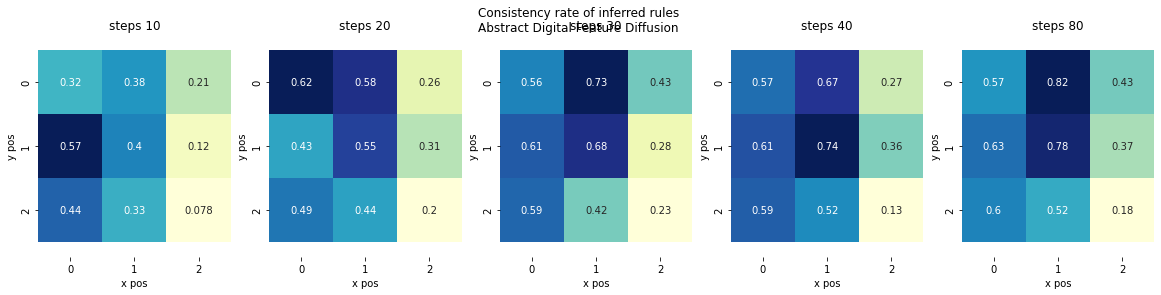

Original panels [0, 1, 2] (class id 11)
Original rule id 14 
non fixed noise stochastic inpainting


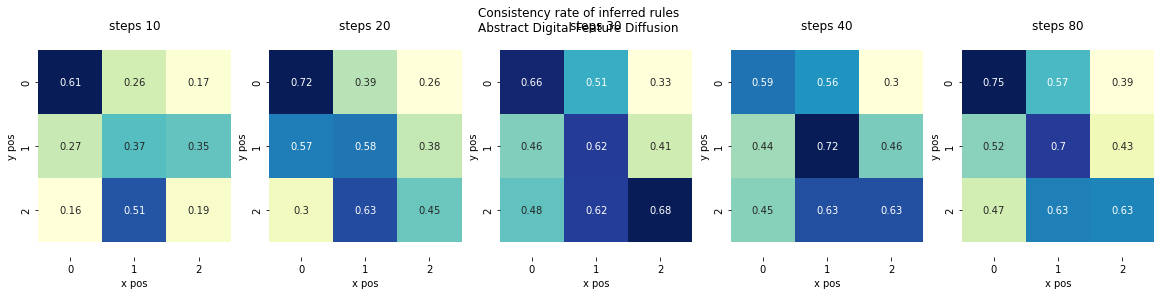

Class 12 has no valid rule, skip
Class 13 has no valid rule, skip
Original panels [0, 1, 2] (class id 14)
Original rule id 17 
non fixed noise stochastic inpainting


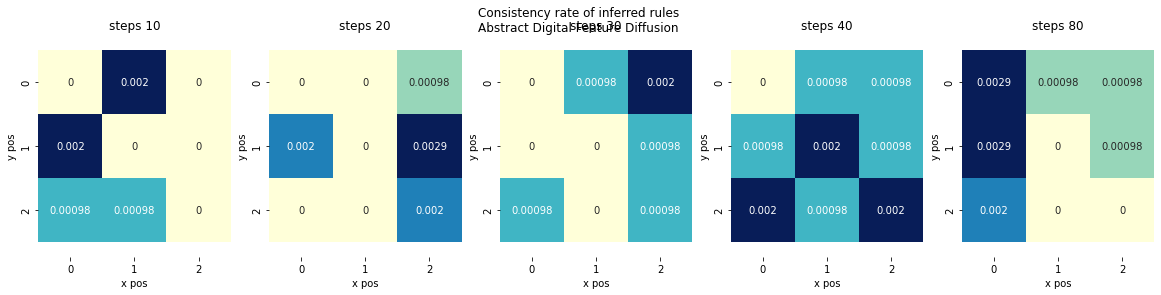

Class 15 has no valid rule, skip
Original panels [0, 1, 2] (class id 16)
Original rule id 19 
non fixed noise stochastic inpainting


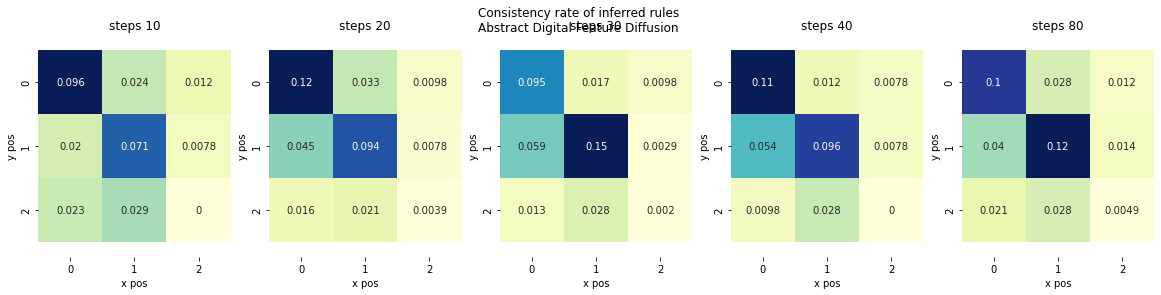

Original panels [0, 1, 2] (class id 17)
Original rule id 21 
non fixed noise stochastic inpainting


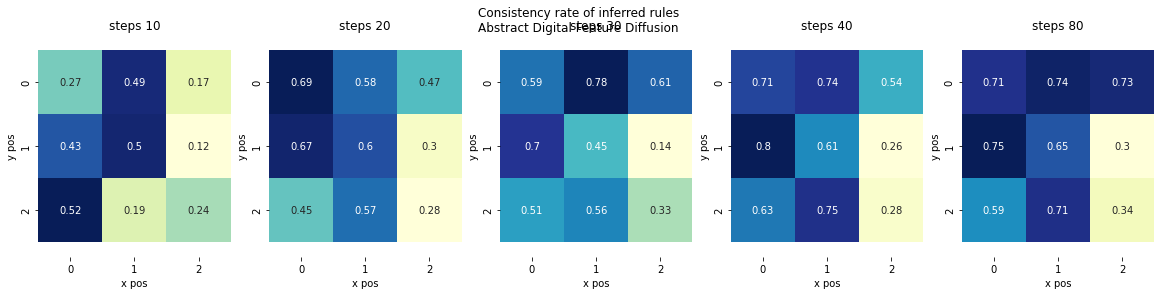

Original panels [0, 1, 2] (class id 18)
Original rule id 22 
non fixed noise stochastic inpainting


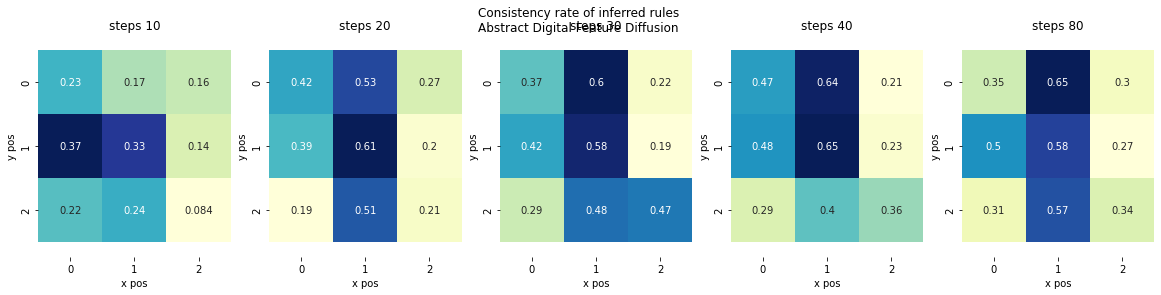

Original panels [0, 1, 2] (class id 19)
Original rule id 23 
non fixed noise stochastic inpainting


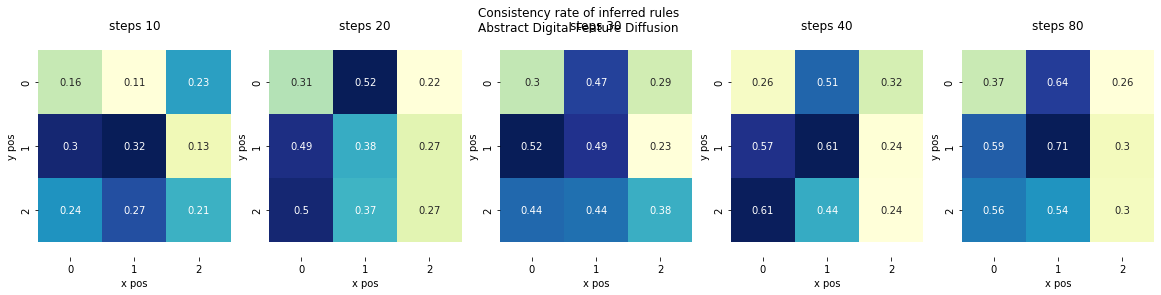

Original panels [0, 1, 2] (class id 20)
Original rule id 24 
non fixed noise stochastic inpainting


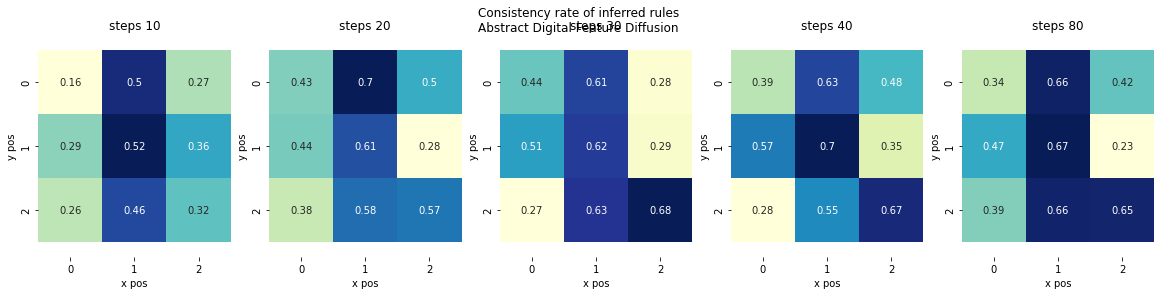

Class 21 has no valid rule, skip
Class 22 has no valid rule, skip
Original panels [0, 1, 2] (class id 23)
Original rule id 27 
non fixed noise stochastic inpainting


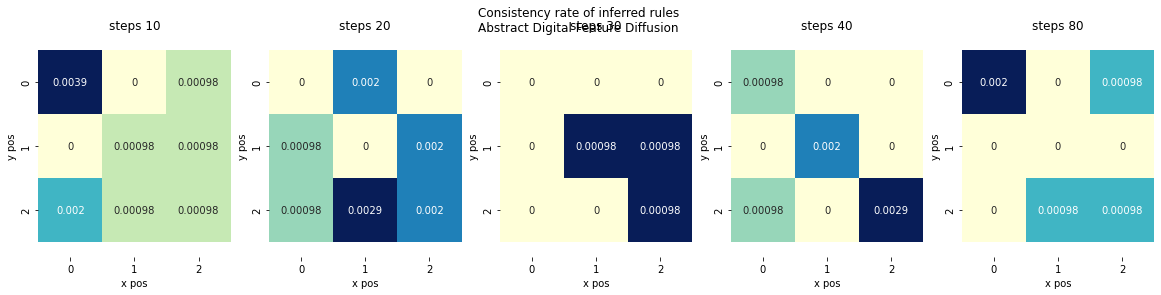

Class 24 has no valid rule, skip
Original panels [0, 1, 2] (class id 25)
Original rule id 29 
non fixed noise stochastic inpainting


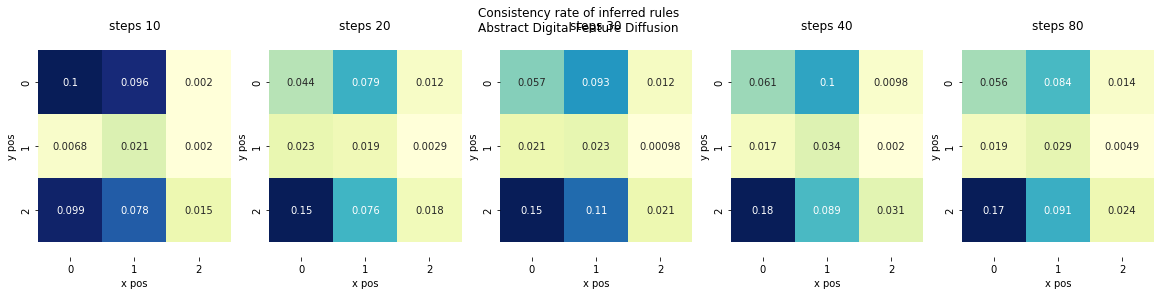

Original panels [0, 1, 2] (class id 26)
Original rule id 30 
non fixed noise stochastic inpainting


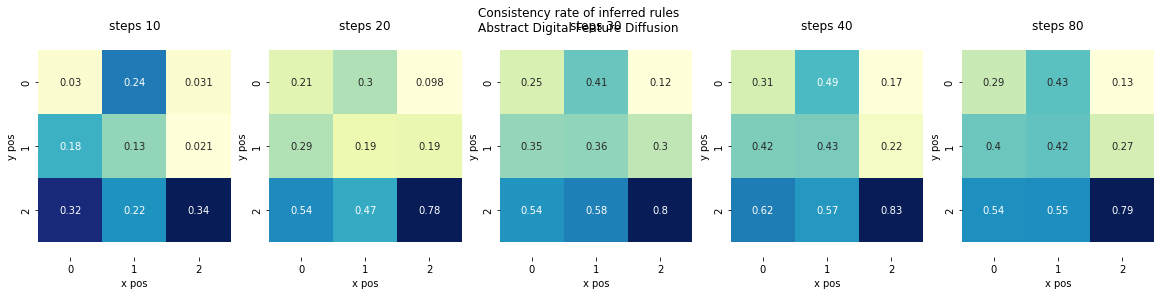

Class 27 has no valid rule, skip
Original panels [0, 1, 2] (class id 28)
Original rule id 32 
non fixed noise stochastic inpainting


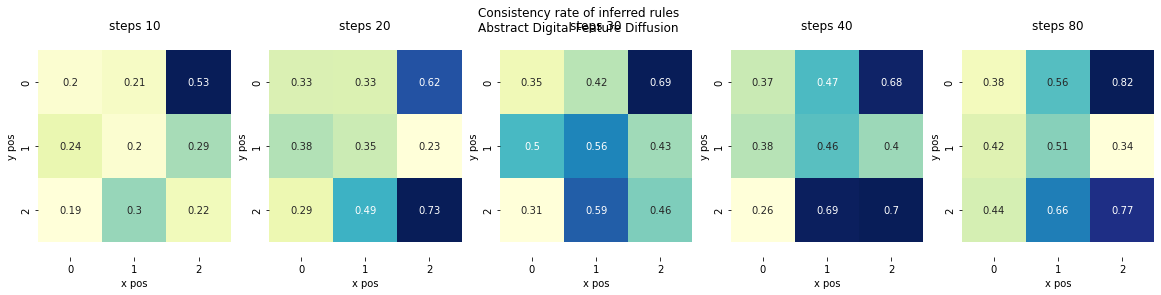

Original panels [0, 1, 2] (class id 29)
Original rule id 33 
non fixed noise stochastic inpainting


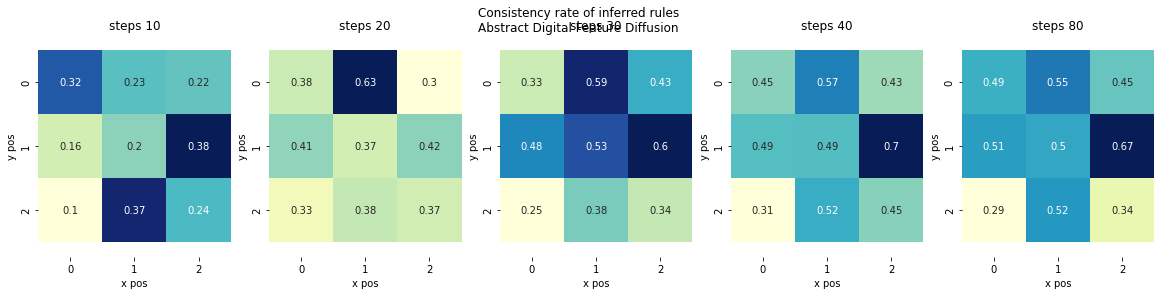

Original panels [0, 1, 2] (class id 30)
Original rule id 34 
non fixed noise stochastic inpainting


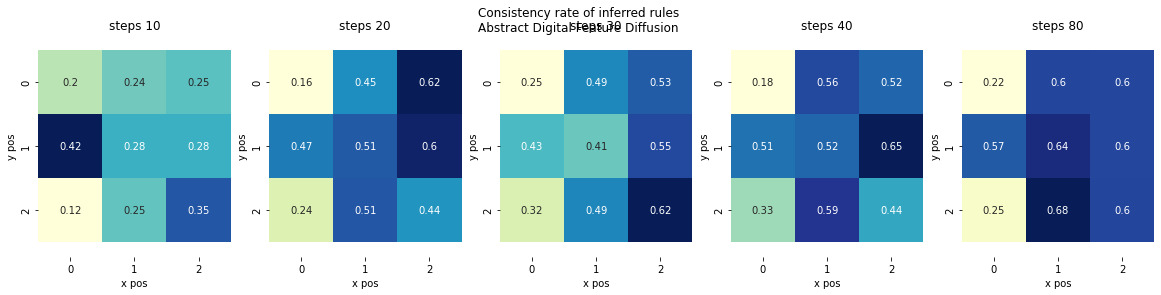

Class 31 has no valid rule, skip
Class 32 has no valid rule, skip
Class 33 has no valid rule, skip
Class 34 has no valid rule, skip


In [9]:
os.makedirs(ckptdir+"/../inpainting_figs", exist_ok=True)
figdir = ckptdir+"/../inpainting_figs"
model_str = f"BigBlnr_abstract_ep{epoch}"
sample_size = 1024
steps2try = [10, 20, 30, 40, 80]
idxs = [0, 1, 2]
for iclass in range(35):
    try:
        attr_tsr = train_data2attr_tsr(train_inputs[iclass, idxs])
        attr_mtg = einops.rearrange(attr_tsr, "b c h w -> c (b h) w")
        orig_rules = get_rule_img(attr_mtg)
        assert len(np.unique(orig_rules)) == 1
        assert np.all(orig_rules != -1)
        orig_rule_id = np.unique(orig_rules)[0] # note this id can be different from iclass
        x_pos, y_pos = 1, 1
        total_steps = 40
        stats_col = {}
        print (f"Original panels {idxs} (class id {iclass})")
        print (f"Original rule id {orig_rule_id} ")
        print("non fixed noise stochastic inpainting")
        for total_steps in steps2try:
            for x_pos in range(3):
                for y_pos in range(3):
                    target_img = (attr_mtg.float().to(device) - Xmean) / Xstd
                    mask_tsr = torch.zeros(target_img.shape[-2:], device=device)
                    mask_tsr[3*x_pos:3*(x_pos+1), 3*y_pos:3*(y_pos+1)] = 1
                    latents = torch.randn(sample_size, 3, 9, 9).to(device)
                    samples = edm_sampler_inpaint(edm, latents, target_img=target_img, mask=mask_tsr,
                                                    num_steps=total_steps, use_ema=False,
                                                    fixed_noise=False).detach()
                    samples = samples * Xstd + Xmean
                    samples_int = torch.round(samples).long().cpu()

                    rules_mat = []
                    for attr_mtg_inpaint in samples_int:
                        rules = get_rule_img(attr_mtg_inpaint)
                        rules_mat.append(rules)
                    rules_mat = np.asarray(rules_mat)
                    stats_col[(total_steps, x_pos, y_pos)] = (rules_mat, (rules_mat[:, x_pos]==orig_rule_id).mean(), (rules_mat[:, x_pos]!=-1).mean())

        pkl.dump(stats_col, open(join(figdir, f"{model_str}_inpainting_rule_consistency_class{iclass}.pkl"), "wb"))                    

        figh, axh = plt.subplots(1, len(steps2try), figsize=(20, 4))
        for i, total_steps in enumerate(steps2try):
            plt.sca(axh[i])
            acc_mat = np.array([[stats_col[total_steps, x_pos, y_pos][1] for y_pos in range(3)] for x_pos in range(3)])
            sns.heatmap(acc_mat, annot=True, cmap="YlGnBu", cbar=False, ax=axh[i])
            axh[i].set_xlabel("x pos")
            axh[i].set_ylabel("y pos")
            plt.axis("equal")
            axh[i].set_title(f"steps {total_steps}")
            
        plt.suptitle("Consistency rate of inferred rules\nAbstract Digital Feature Diffusion")
        plt.savefig(join(figdir, f"{model_str}_inpainting_rule_consistency_class{iclass}.png"), dpi=300)
        plt.savefig(join(figdir, f"{model_str}_inpainting_rule_consistency_class{iclass}.pdf"), dpi=300)
        plt.show()
    except AssertionError:
        print(f"Class {iclass} has no valid rule, skip")
        continue

### Abstract attribute with one hot encoding

In [24]:
DATASET="RAVEN10_abstract_onehot"
config_onehot = edict()
config_onehot.channel_mult = [1, 2, 4, 4]
config_onehot.model_channels = 64
config_onehot.attn_resolutions = [0,1,2]
config_onehot.layers_per_block = 1
config_onehot.num_fid_sample = 5000
config_onehot.fid_batch_size = 1024
config_onehot.channels = 27
config_onehot.img_size = 9
config_onehot.device = "cuda"
config_onehot.sigma_min = 0.002
config_onehot.sigma_max = 80.0
config_onehot.rho = 7.0 
config_onehot.sigma_data = 0.5
device = "cuda"

In [20]:
epoch = 99999
model = create_model(config_onehot)
ckptdir = r"/n/home12/binxuwang/Github/mini_edm/exps/base_RAVEN10_abstract_onehot_20240201-0147/checkpoints"
model.load_state_dict(torch.load(ckptdir + f"/ema_{epoch}.pth"))

<All keys matched successfully>

## Training Dynamics

In [252]:
from edm_utils import parse_train_logfile
from os.path import join

In [254]:
exproot = r"/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps"
df_wide = parse_train_logfile(join(exproot,"Wide_RAVEN10_abstract_20240206-2323","std.log"))

             timestamp level  step  learning_rate  average_loss  batch_loss
0  2024-02-06 23:24:33  INFO     0       0.000000      1.933217    1.933217
1  2024-02-06 23:24:41  INFO   100       0.000004      2.040321    2.044233
2  2024-02-06 23:24:47  INFO   200       0.000008      1.974165    1.897349
3  2024-02-06 23:24:52  INFO   300       0.000012      1.907248    1.712826
4  2024-02-06 23:24:58  INFO   400       0.000016      1.838222    1.622334


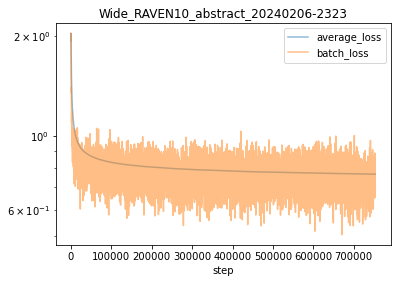

In [259]:
df_wide.plot("step", ["average_loss","batch_loss"], logy=True, alpha=0.5)
plt.title("Wide_RAVEN10_abstract_20240206-2323")
plt.show()

             timestamp level  step  learning_rate  average_loss  batch_loss
0  2024-02-06 23:24:47  INFO     0       0.000000      1.991650    1.991650
1  2024-02-06 23:24:56  INFO   100       0.000004      2.072678    1.998352
2  2024-02-06 23:25:01  INFO   200       0.000008      1.895700    1.505616
3  2024-02-06 23:25:07  INFO   300       0.000012      1.716550    1.215978
4  2024-02-06 23:25:12  INFO   400       0.000016      1.571327    1.094095


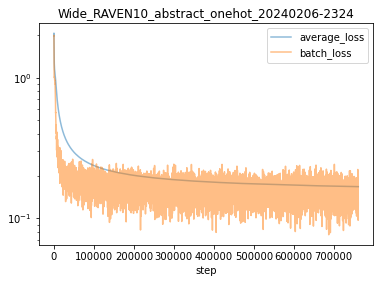

In [258]:
exproot = r"/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps"
df_wideOH = parse_train_logfile(join(exproot,"Wide_RAVEN10_abstract_onehot_20240206-2324","std.log"))
df_wideOH.plot("step", ["average_loss","batch_loss"], logy=True, alpha=0.5)
plt.title("Wide_RAVEN10_abstract_onehot_20240206-2324")
plt.show()